# SETUP

## Check environment

In [52]:
USE_GPU = True

## Libraries

In [53]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_3_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction, inferenceLSTM
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData
from src.data_utils import mice

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

Using GPU to train
2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [54]:
conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json").data

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(conf["workspace"]["saved_model_plot_dir"])
cleanDir(conf["workspace"]["saved_model_weight_dir"])
cleanDir(conf["workspace"]["data_statistic_dir"])
cleanDir(conf["workspace"]["data_by_station_dir"])
cleanDir(conf["workspace"]["data_by_location_dir"])
cleanDir(conf["workspace"]["best_reduction_models_dir"])
cleanDir(conf["workspace"]["best_reduced_data_dir"])

# CMAQ DATA

## Load dataset

### Raw data

In [55]:
df_cmaq_raw = []
for csv_file in glob.glob(f'{conf["dataset"]["cmaq"]["file_dir"]}/*'):
    df_current_station = pd.read_csv(csv_file).dropna(axis=1, how="all")
    station = csv_file.split("/")[-1].split(".")[0]
    print(f"{csv_file} - {len(df_current_station)} records")
    df_current_station["station"] = station
    df_cmaq_raw.append(df_current_station)
df_cmaq_raw = pd.concat(df_cmaq_raw, axis=0, ignore_index=True)
df_cmaq_raw

/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/216.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/212.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/201.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/215.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/213.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/214.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/211.csv - 7476 records


Date      Time       PM25       PM10        O3       SO2  \
0      01/01/2022   7:00:00   4.962867  17.781220  0.098060  0.000077   
1      01/01/2022   8:00:00   6.538577  23.655580  0.079992  0.000105   
2      01/01/2022   9:00:00   7.173492  25.594369  0.063973  0.000132   
3      01/01/2022  10:00:00   7.377719  26.746649  0.052615  0.000131   
4      01/01/2022  11:00:00   6.629785  23.692133  0.044166  0.000090   
...           ...       ...        ...        ...       ...       ...   
52327  31/12/2022   1:00:00  12.338016  44.975750  0.027149  0.000055   
52328  31/12/2022   2:00:00  12.207455  43.493079  0.026779  0.000055   
52329  31/12/2022   3:00:00  12.345228  45.676369  0.026994  0.000056   
52330  31/12/2022   4:00:00  12.455814  47.065511  0.026826  0.000057   
52331  31/12/2022   5:00:00  12.337399  44.779930  0.026044  0.000057   

            NO2 station  
0      0.000981     216  
1      0.001294     216  
2      0.001035     216  
3      0.000818     216  
4      0.000607     216  
...         ...     ...  
52327  0.000068     211  
52328  0.000067     211  
52329  0.000067     211  
52330  0.000067     211  
52331  0.000066     211  

[52332 rows x 8 columns]

### Handle metadata

In [56]:
# Merge Date and Time columns
df_cmaq_raw["time"] = df_cmaq_raw["Time"] + " " + df_cmaq_raw["Date"]
df_cmaq_raw["time"] = df_cmaq_raw["time"].apply(lambda element: datetime.strptime(element, "%H:%M:%S %d/%m/%Y"))
df_cmaq_raw = df_cmaq_raw.assign(time=pd.to_datetime(df_cmaq_raw["time"]))
df_cmaq_raw = df_cmaq_raw.assign(station=df_cmaq_raw["station"].astype("int64"))
df_cmaq_raw.drop(columns=["Date", "Time"], inplace=True)

# Rename columns
df_cmaq_raw = df_cmaq_raw.rename(columns={name: f"{name.lower()}" for name in df_cmaq_raw.columns})

# Sort data by "station" then "time"
df_cmaq_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Set index
df_cmaq_raw.set_index("time", inplace=True)

# Print
df_cmaq_raw

pm25       pm10        o3       so2       no2  \
time                                                                      
2022-01-01 07:00:00   8.070718  28.069728  0.098301  0.000047  0.001115   
2022-01-01 08:00:00   9.922100  35.973360  0.078072  0.000062  0.001141   
2022-01-01 09:00:00  11.191617  40.858557  0.061198  0.000082  0.000941   
2022-01-01 10:00:00  11.655973  43.331055  0.050983  0.000087  0.000761   
2022-01-01 11:00:00  11.074831  39.380184  0.042117  0.000068  0.000600   
...                        ...        ...       ...       ...       ...   
2022-12-31 01:00:00   9.481827  34.121409  0.026421  0.000149  0.002276   
2022-12-31 02:00:00   9.389163  34.542116  0.026171  0.000148  0.002208   
2022-12-31 03:00:00   9.472814  34.649932  0.026087  0.000151  0.002249   
2022-12-31 04:00:00  10.222586  36.111460  0.026347  0.000166  0.002680   
2022-12-31 05:00:00  10.196095  36.470190  0.026102  0.000164  0.002590   

                     station  
time                          
2022-01-01 07:00:00      201  
2022-01-01 08:00:00      201  
2022-01-01 09:00:00      201  
2022-01-01 10:00:00      201  
2022-01-01 11:00:00      201  
...                      ...  
2022-12-31 01:00:00      216  
2022-12-31 02:00:00      216  
2022-12-31 03:00:00      216  
2022-12-31 04:00:00      216  
2022-12-31 05:00:00      216  

[52332 rows x 6 columns]

In [57]:
df_cmaq_raw.isnull().sum()

pm25       0
pm10       0
o3         0
so2        0
no2        0
station    0
dtype: int64

In [58]:
all_resampled_dfs = []
for station in df_cmaq_raw["station"].unique():
    df_cmaq_current_station = df_cmaq_raw[df_cmaq_raw["station"] == station]
    df_cmaq_current_station_resampled = df_cmaq_current_station.resample("D").mean()
    df_cmaq_current_station_resampled["station"] = station
    all_resampled_dfs.append(df_cmaq_current_station_resampled)

df_cmaq_daily = pd.concat(all_resampled_dfs, axis=0)
print(df_cmaq_daily["station"].unique())
df_cmaq_daily

[201 211 212 213 214 215 216]


pm25       pm10        o3       so2       no2  station
time                                                                   
2022-01-01  15.269127  48.407405  0.038950  0.000095  0.001809      201
2022-01-02  16.298580  59.344891  0.027448  0.000107  0.002403      201
2022-01-03  15.532542  56.512608  0.027952  0.000121  0.002359      201
2022-01-04  19.030452  66.483882  0.027218  0.000206  0.003297      201
2022-01-05  26.266464  82.340143  0.027566  0.000388  0.004734      201
...               ...        ...       ...       ...       ...      ...
2022-12-27  28.235250  78.640922  0.028089  0.001259  0.007881      216
2022-12-28  26.291384  77.514532  0.026661  0.000907  0.006642      216
2022-12-29  26.971063  63.326358  0.026366  0.000821  0.012799      216
2022-12-30  19.645784  52.679791  0.028655  0.000530  0.007603      216
2022-12-31   9.745557  34.890883  0.026313  0.000156  0.002431      216

[2555 rows x 6 columns]

# AOD DATA

## Load 2022 dataset

In [59]:
df_aod_raw_2022 = pd.read_excel(conf["dataset"]["aod2022"]["file_dir"])

print(df_aod_raw_2022.columns)
df_aod_raw_2022

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')


time  ID       pm25        lat         lon   PM25_3km        TMP  \
0    2022-01-01  S4  23.768238  10.815839  106.717396  22.025597  28.261583   
1    2022-01-01  S5  14.221014  10.776415  106.687955  22.705284  27.787918   
2    2022-01-01  S6  21.405015  10.780482  106.659511  23.503082  27.787918   
3    2022-01-01  S7  21.695652  10.783456  106.700622  22.705284  27.787918   
4    2022-01-02  S4  22.154723  10.815839  106.717396  22.711113  25.827082   
..          ...  ..        ...        ...         ...        ...        ...   
993  2022-12-30  S6  33.091428  10.780482  106.659511  19.854403  24.979719   
994  2022-12-30  S7  40.166667  10.783456  106.700622  19.137615  24.979719   
995  2022-12-31  S4  27.879261  10.815839  106.717396  28.223820  26.630608   
996  2022-12-31  S6  28.854069  10.780482  106.659511  27.658358  25.364861   
997  2022-12-31  S7  33.958333  10.783456  106.700622  26.659830  25.364861   

            RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0    57.233841  721.996887  2.003031  ...        2327.256348   2.546965   
1    61.073841  659.863586  1.885687  ...        7249.776367  21.703104   
2    61.073841  659.863586  1.885687  ...        2345.868408   6.057246   
3    61.073841  659.863586  1.885687  ...        6885.987305  18.537305   
4    57.916595  619.779785  1.286289  ...        2327.256348   2.546965   
..         ...         ...       ...  ...                ...        ...   
993  64.868401  680.533081  3.893373  ...        2345.868408   6.057246   
994  64.868401  680.533081  3.893373  ...        6885.987305  18.537305   
995  55.437901  607.372803  4.217750  ...        2327.256348   2.546965   
996  62.377899  799.122803  4.161542  ...        2345.868408   6.057246   
997  62.377899  799.122803  4.161542  ...        6885.987305  18.537305   

         BARELAND      BUILTUP   CROPLAND    GRASSLAND     TREECOVER  \
0     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
1      395.082094  877872.4121    0.00000    98.770523  121487.74380   
2    10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
3      296.311570  764977.7039    0.00000  1876.639945  232011.95950   
4     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
..            ...          ...        ...          ...           ...   
993  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
994    296.311570  764977.7039    0.00000  1876.639945  232011.95950   
995   1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
996  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
997    296.311570  764977.7039    0.00000  1876.639945  232011.95950   

           WATER         NDVI  \
0    61731.57713  1818.661486   
1        0.00000  1721.431568   
2        0.00000  1879.344348   
3        0.00000  2700.122924   
4    61731.57713  1818.661486   
..           ...          ...   
993      0.00000  1879.344348   
994      0.00000  2700.122924   
995  61731.57713  1818.661486   
996      0.00000  1879.344348   
997      0.00000  2700.122924   

                                                  Name  
0    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
1     Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3  
2                             MobiFone Thành Thái, Q10  
3                                               ĐSQ Mỹ  
4    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
..                                                 ...  
993                           MobiFone Thành Thái, Q10  
994                                             ĐSQ Mỹ  
995  Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
996                           MobiFone Thành Thái, Q10  
997                                             ĐSQ Mỹ  

[998 rows x 25 columns]

In [60]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2022 = df_aod_raw_2022.assign(time=pd.to_datetime(df_aod_raw_2022["time"]))

# Set "time" column as index
#df_aod_raw_2022.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={name: name.lower() for name in df_aod_raw_2022.columns})

# Rename oid to station
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={"oid": "station"})

# Drop unnecessary columns
df_aod_raw_2022.drop(columns=["name", "id"], axis=1, inplace=True)

# Print
df_aod_raw_2022

time       pm25        lat         lon   pm25_3km        tmp  \
0   2022-01-01  23.768238  10.815839  106.717396  22.025597  28.261583   
1   2022-01-01  14.221014  10.776415  106.687955  22.705284  27.787918   
2   2022-01-01  21.405015  10.780482  106.659511  23.503082  27.787918   
3   2022-01-01  21.695652  10.783456  106.700622  22.705284  27.787918   
4   2022-01-02  22.154723  10.815839  106.717396  22.711113  25.827082   
..         ...        ...        ...         ...        ...        ...   
993 2022-12-30  33.091428  10.780482  106.659511  19.854403  24.979719   
994 2022-12-30  40.166667  10.783456  106.700622  19.137615  24.979719   
995 2022-12-31  27.879261  10.815839  106.717396  28.223820  26.630608   
996 2022-12-31  28.854069  10.780482  106.659511  27.658358  25.364861   
997 2022-12-31  33.958333  10.783456  106.700622  26.659830  25.364861   

            rh        hpbl      wspd         pres2m  ...  road_den_1km  \
0    57.233841  721.996887  2.003031  101227.000000  ...     22.923040   
1    61.073841  659.863586  1.885687  101204.875000  ...     23.362053   
2    61.073841  659.863586  1.885687  101204.875000  ...     33.629780   
3    61.073841  659.863586  1.885687  101204.875000  ...     27.462461   
4    57.916595  619.779785  1.286289  101201.015625  ...     22.923040   
..         ...         ...       ...            ...  ...           ...   
993  64.868401  680.533081  3.893373  101393.398438  ...     33.629780   
994  64.868401  680.533081  3.893373  101393.398438  ...     27.462461   
995  55.437901  607.372803  4.217750  101322.437500  ...     22.923040   
996  62.377899  799.122803  4.161542  101297.140625  ...     33.629780   
997  62.377899  799.122803  4.161542  101297.140625  ...     27.462461   

     prim_road_len_1km  near_dist      bareland      builtup   cropland  \
0          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
1          7249.776367  21.703104    395.082094  877872.4121    0.00000   
2          2345.868408   6.057246  10370.904960  885181.4309    0.00000   
3          6885.987305  18.537305    296.311570  764977.7039    0.00000   
4          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
..                 ...        ...           ...          ...        ...   
993        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
994        6885.987305  18.537305    296.311570  764977.7039    0.00000   
995        2327.256348   2.546965   1876.639945  841524.8595  296.31157   
996        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
997        6885.987305  18.537305    296.311570  764977.7039    0.00000   

       grassland     treecover        water         ndvi  
0    3753.279890   91461.50468  61731.57713  1818.661486  
1      98.770523  121487.74380      0.00000  1721.431568  
2    8099.182920   95807.40771      0.00000  1879.344348  
3    1876.639945  232011.95950      0.00000  2700.122924  
4    3753.279890   91461.50468  61731.57713  1818.661486  
..           ...           ...          ...          ...  
993  8099.182920   95807.40771      0.00000  1879.344348  
994  1876.639945  232011.95950      0.00000  2700.122924  
995  3753.279890   91461.50468  61731.57713  1818.661486  
996  8099.182920   95807.40771      0.00000  1879.344348  
997  1876.639945  232011.95950      0.00000  2700.122924  

[998 rows x 23 columns]

In [61]:
df_aod_raw_2022["station"].unique()

array([214, 215, 216, 201])

## Load 2018-2021 dataset

In [62]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])

print(df_aod_raw_2021.columns)
df_aod_raw_2021

Index(['time', 'ID', 'pm25', 'Lat', 'Lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'POP', 'ROAD_DEN_1km', 'PRIM_ROAD_LEN_1km', 'NEAR_DIST',
       'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND', 'TREECOVER', 'WATER',
       'NDVI', 'AOD'],
      dtype='object')


time   ID       pm25        Lat         Lon   PM25_3km        TMP  \
0       1/1/2018  201  31.391304  10.783057  106.700606  34.919998  25.204139   
1       1/1/2018  202  29.615625  10.762638  106.682027  32.099998  25.100436   
2       1/2/2018  201  37.458333  10.783057  106.700606  51.830002  24.726431   
3       1/2/2018  202  36.244792  10.762638  106.682027  44.619999  24.663358   
4       1/3/2018  201  68.083333  10.783057  106.700606  38.240002  26.095087   
...          ...  ...        ...        ...         ...        ...        ...   
2886  12/31/2021  211  14.474306  10.870190  106.796200  17.930000  23.428631   
2887  12/31/2021  212  20.100752  10.740760  106.617000  20.010000  24.914532   
2888  12/31/2021  213  23.240539  10.816350  106.620500  20.700001  24.171986   
2889  12/31/2021  214  20.549839  10.815570  106.717500  21.040001  24.367620   
2890  12/31/2021  216  19.637165  10.780630  106.659300  20.840000  22.830532   

             RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0     70.056728  455.131335  2.352895  ...        6885.987305  18.537305   
1     71.060891  457.243423  2.344162  ...        7097.612305   3.822386   
2     73.425826  339.083720  1.903761  ...        6885.987305  18.537305   
3     73.870799  338.530190  1.885305  ...        7097.612305   3.822386   
4     77.793432  367.190738  1.293329  ...        6885.987305  18.537305   
...         ...         ...       ...  ...                ...        ...   
2886  75.209297  134.323181  1.485907  ...           0.000000  49.023548   
2887  64.741638  212.347687  2.196620  ...        2529.119629  20.331284   
2888  67.759666  145.481979  2.459679  ...           0.000000   7.560823   
2889  67.038559  168.648315  2.101351  ...        2327.256348   2.546965   
2890  79.056641  184.397690  2.316177  ...        2345.868408   6.057246   

          BARELAND      BUILTUP     CROPLAND     GRASSLAND     TREECOVER  \
0       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
1       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
2       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
3       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
4       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
...            ...          ...          ...           ...           ...   
2886   1086.475758  724185.4777   592.623140  46915.998620  225888.18710   
2887  16297.136360  892984.3022  7506.559780  26470.500280   57681.98567   
2888  13136.479610  928245.3791  4247.132507  17581.153170   34964.76529   
2889   1876.639945  841524.8595   296.311570   3753.279890   91461.50468   
2890  10370.904960  885181.4309     0.000000   8099.182920   95807.40771   

             WATER         NDVI       AOD  
0         0.000000  2700.122924       NaN  
1     35063.535810  1765.098553       NaN  
2         0.000000  2700.122924  1.110117  
3     35063.535810  1765.098553  1.277641  
4         0.000000  2700.122924  1.439045  
...            ...          ...       ...  
2886      0.000000  3579.160484       NaN  
2887      0.000000  3266.283480       NaN  
2888   1481.557851  2535.126792  0.272610  
2889  61731.577130  1818.661486  0.524898  
2890      0.000000  1879.344348       NaN  

[2891 rows x 22 columns]

In [63]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])

# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns}, inplace=True)

# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)

# Print
df_aod_raw_2021

time  station       pm25        lat         lon   pm25_3km  \
0    2018-01-01      201  31.391304  10.783057  106.700606  34.919998   
1    2018-01-01      202  29.615625  10.762638  106.682027  32.099998   
2    2018-01-02      201  37.458333  10.783057  106.700606  51.830002   
3    2018-01-02      202  36.244792  10.762638  106.682027  44.619999   
4    2018-01-03      201  68.083333  10.783057  106.700606  38.240002   
...         ...      ...        ...        ...         ...        ...   
2886 2021-12-31      211  14.474306  10.870190  106.796200  17.930000   
2887 2021-12-31      212  20.100752  10.740760  106.617000  20.010000   
2888 2021-12-31      213  23.240539  10.816350  106.620500  20.700001   
2889 2021-12-31      214  20.549839  10.815570  106.717500  21.040001   
2890 2021-12-31      216  19.637165  10.780630  106.659300  20.840000   

            tmp         rh        hpbl      wspd  ...  prim_road_len_1km  \
0     25.204139  70.056728  455.131335  2.352895  ...        6885.987305   
1     25.100436  71.060891  457.243423  2.344162  ...        7097.612305   
2     24.726431  73.425826  339.083720  1.903761  ...        6885.987305   
3     24.663358  73.870799  338.530190  1.885305  ...        7097.612305   
4     26.095087  77.793432  367.190738  1.293329  ...        6885.987305   
...         ...        ...         ...       ...  ...                ...   
2886  23.428631  75.209297  134.323181  1.485907  ...           0.000000   
2887  24.914532  64.741638  212.347687  2.196620  ...        2529.119629   
2888  24.171986  67.759666  145.481979  2.459679  ...           0.000000   
2889  24.367620  67.038559  168.648315  2.101351  ...        2327.256348   
2890  22.830532  79.056641  184.397690  2.316177  ...        2345.868408   

      near_dist      bareland      builtup     cropland     grassland  \
0     18.537305    296.311570  764977.7039     0.000000   1876.639945   
1      3.822386    395.082094  947604.4016     0.000000   2963.115702   
2     18.537305    296.311570  764977.7039     0.000000   1876.639945   
3      3.822386    395.082094  947604.4016     0.000000   2963.115702   
4     18.537305    296.311570  764977.7039     0.000000   1876.639945   
...         ...           ...          ...          ...           ...   
2886  49.023548   1086.475758  724185.4777   592.623140  46915.998620   
2887  20.331284  16297.136360  892984.3022  7506.559780  26470.500280   
2888   7.560823  13136.479610  928245.3791  4247.132507  17581.153170   
2889   2.546965   1876.639945  841524.8595   296.311570   3753.279890   
2890   6.057246  10370.904960  885181.4309     0.000000   8099.182920   

         treecover         water         ndvi       aod  
0     232011.95950      0.000000  2700.122924       NaN  
1      13926.64380  35063.535810  1765.098553       NaN  
2     232011.95950      0.000000  2700.122924  1.110117  
3      13926.64380  35063.535810  1765.098553  1.277641  
4     232011.95950      0.000000  2700.122924  1.439045  
...            ...           ...          ...       ...  
2886  225888.18710      0.000000  3579.160484       NaN  
2887   57681.98567      0.000000  3266.283480       NaN  
2888   34964.76529   1481.557851  2535.126792  0.272610  
2889   91461.50468  61731.577130  1818.661486  0.524898  
2890   95807.40771      0.000000  1879.344348       NaN  

[2891 rows x 22 columns]

In [64]:
df_aod_raw_2021["station"].unique()

array([201, 202, 211, 212, 213, 214, 215, 216])

## Merge dataset

In [65]:
# Remove "pres2m" column in 2022 because it doesn't have value in 2021
df_aod_raw_2022.drop(["pres2m"], axis=1, inplace=True)

# Start merging
df_aod_raw = pd.concat([df_aod_raw_2021, df_aod_raw_2022], axis=0)

# Sort data by "station" then "time"
df_aod_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Set index
df_aod_raw.set_index("time", inplace=True)

# Print
df_aod_raw

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2018-01-01      201  31.391304  10.783057  106.700606  34.919998  25.204139   
2018-01-02      201  37.458333  10.783057  106.700606  51.830002  24.726431   
2018-01-03      201  68.083333  10.783057  106.700606  38.240002  26.095087   
2018-01-04      201  51.260870  10.783057  106.700606  40.259998  26.514926   
2018-01-05      201  18.909091  10.783057  106.700606  21.690001  25.483535   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2018-01-01  70.056728  455.131335  2.352895  20680.62695  ...   
2018-01-02  73.425826  339.083720  1.903761  20680.62695  ...   
2018-01-03  77.793432  367.190738  1.293329  20680.62695  ...   
2018-01-04  82.982475  462.504210  1.588872  20680.62695  ...   
2018-01-05  93.046504  324.735356  2.505876  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2018-01-01  1876.639945  232011.95950    0.0  2700.122924       NaN  
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  1.110117  
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  1.439045  
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  0.588595  
2018-01-05  1876.639945  232011.95950    0.0  2700.122924       NaN  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348       NaN  

[3889 rows x 21 columns]

In [66]:
df_aod_raw.to_csv('df_aod_raw.csv', index=True)

## EDA

In [67]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')
display(df_aod_stat.iloc[:, 0:7])
display(df_aod_stat.iloc[:, 7:14])
display(df_aod_stat.iloc[:, 14:22])

station         pm25          lat          lon     pm25_3km  \
count  3889.000000  3889.000000  3889.000000  3889.000000  3889.000000   
mean    207.520185    23.011572    10.788306   106.689282    20.046538   
std       6.563450    10.301408     0.025632     0.037486     9.668466   
min     201.000000     4.333333    10.740760   106.617000     5.440000   
25%     201.000000    15.444042    10.780482   106.659511    13.147358   
50%     202.000000    20.583333    10.783057   106.700606    17.610001   
75%     214.000000    28.387500    10.783456   106.700606    24.095436   
max     216.000000    87.416667    10.870190   106.796200    96.139999   

               tmp           rh  
count  3889.000000  3889.000000  
mean     27.486412    75.352473  
std       1.330104     8.409504  
min      21.016206    48.819080  
25%      26.632843    69.889214  
50%      27.570251    75.316635  
75%      28.413069    81.705930  
max      33.235374    94.121568

hpbl         wspd           pop  road_den_1km  \
count  3889.000000  3889.000000   3889.000000   3889.000000   
mean    581.026019     3.000106  29817.660439     27.142390   
std     147.090395     0.961473  15836.834517      4.811024   
min      63.078468     1.076171  14886.636720     18.211647   
25%     481.499541     2.329683  20680.626950     23.362053   
50%     578.328613     2.836771  20680.626950     27.462461   
75%     678.799988     3.507094  35151.593750     27.462461   
max    1367.739014     8.555794  64615.492190     37.829433   

       prim_road_len_1km    near_dist      bareland  
count        3889.000000  3889.000000   3889.000000  
mean         4713.665609    14.797250   3729.457120  
std          2633.314899    10.196835   5363.607284  
min             0.000000     2.546965    296.311570  
25%          2345.868408     6.057246    296.311570  
50%          6885.987305    18.537305    395.082094  
75%          6885.987305    18.537305  10370.904960  
max          7249.776367    49.023548  16297.136360

builtup     cropland     grassland      treecover         water  \
count    3889.000000  3889.000000   3889.000000    3889.000000   3889.000000   
mean   826149.166557   791.891211   7445.402819  151188.057970  10303.855798   
std     68115.590713  2014.178049  10884.016211   81458.618501  21540.755659   
min    724185.477700     0.000000     98.770523   13926.643800      0.000000   
25%    764977.703900     0.000000   1876.639945   91461.504680      0.000000   
50%    841524.859500     0.000000   2963.115702  121487.743800      0.000000   
75%    885181.430900   296.311570   8099.182920  232011.959500   1481.557851   
max    947604.401600  7506.559780  46915.998620  232011.959500  61731.577130   

              ndvi         aod  
count  3889.000000  661.000000  
mean   2418.324453    0.682687  
std     534.284396    0.520347  
min    1721.431568    0.001282  
25%    1818.661486    0.298638  
50%    2700.122924    0.502724  
75%    2700.122924    0.933905  
max    3579.160484    3.098711

In [68]:
df_aod_raw.isnull().sum()

station                 0
pm25                    0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  3228
dtype: int64

### Statistic for each station

In [69]:
for station in df_aod_raw["station"].unique():
    df_current_station = df_aod_raw[df_aod_raw["station"] == station]
    print(f"Station = {station}")
    print(f"Number of records: {len(df_current_station)}")
    print(f"Start date = {df_current_station.index[0]}, end data = {df_current_station.index[-1]}")
    print("=" * 100)

Station = 201
Number of records: 1711
Start date = 2018-01-01 00:00:00, end data = 2022-12-31 00:00:00
Station = 202
Number of records: 253
Start date = 2018-01-01 00:00:00, end data = 2019-03-31 00:00:00
Station = 211
Number of records: 173
Start date = 2021-03-01 00:00:00, end data = 2021-12-31 00:00:00
Station = 212
Number of records: 249
Start date = 2021-03-01 00:00:00, end data = 2021-12-31 00:00:00
Station = 213
Number of records: 226
Start date = 2021-03-01 00:00:00, end data = 2021-12-31 00:00:00
Station = 214
Number of records: 500
Start date = 2021-03-01 00:00:00, end data = 2022-12-31 00:00:00
Station = 215
Number of records: 232
Start date = 2021-03-01 00:00:00, end data = 2022-07-07 00:00:00
Station = 216
Number of records: 545
Start date = 2021-04-02 00:00:00, end data = 2022-12-31 00:00:00


### Correlation matrix

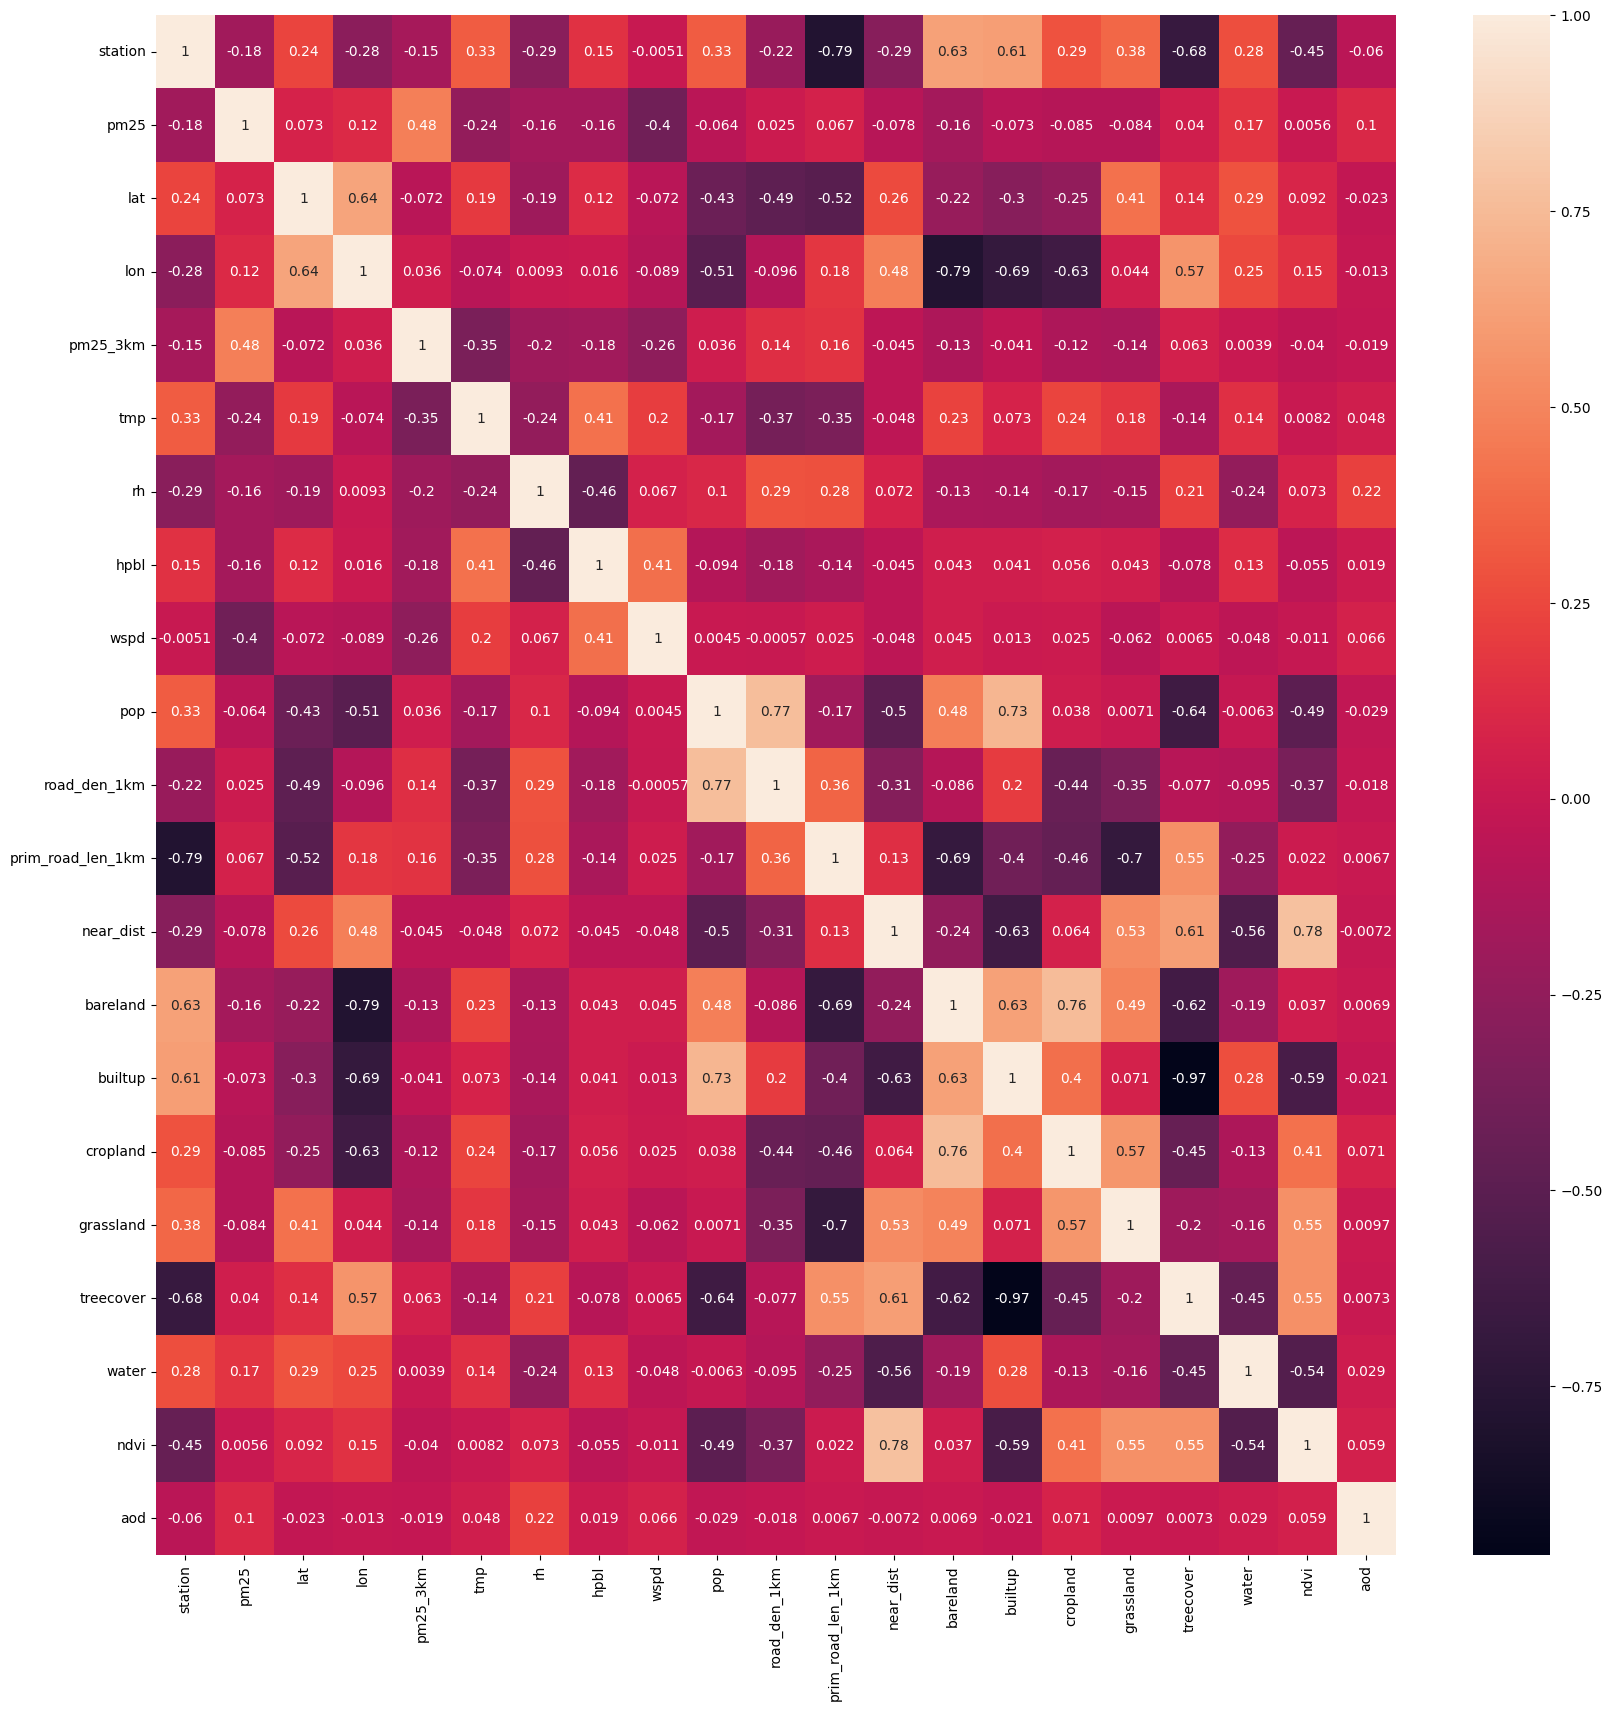

In [70]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df_aod_raw.corr(), annot=True, ax=ax)
plt.show()

## Preprocessing

### Define label, static features and dynamic features

In [71]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['aod', 'pm25_3km', 'hpbl', 'wspd', 'rh', 'tmp']
aod_all_stations = [np.int64(201), np.int64(202), np.int64(211), np.int64(212), np.int64(213), np.int64(214), np.int64(215), np.int64(216)]


### Fill "aod" column


Handling for station 201



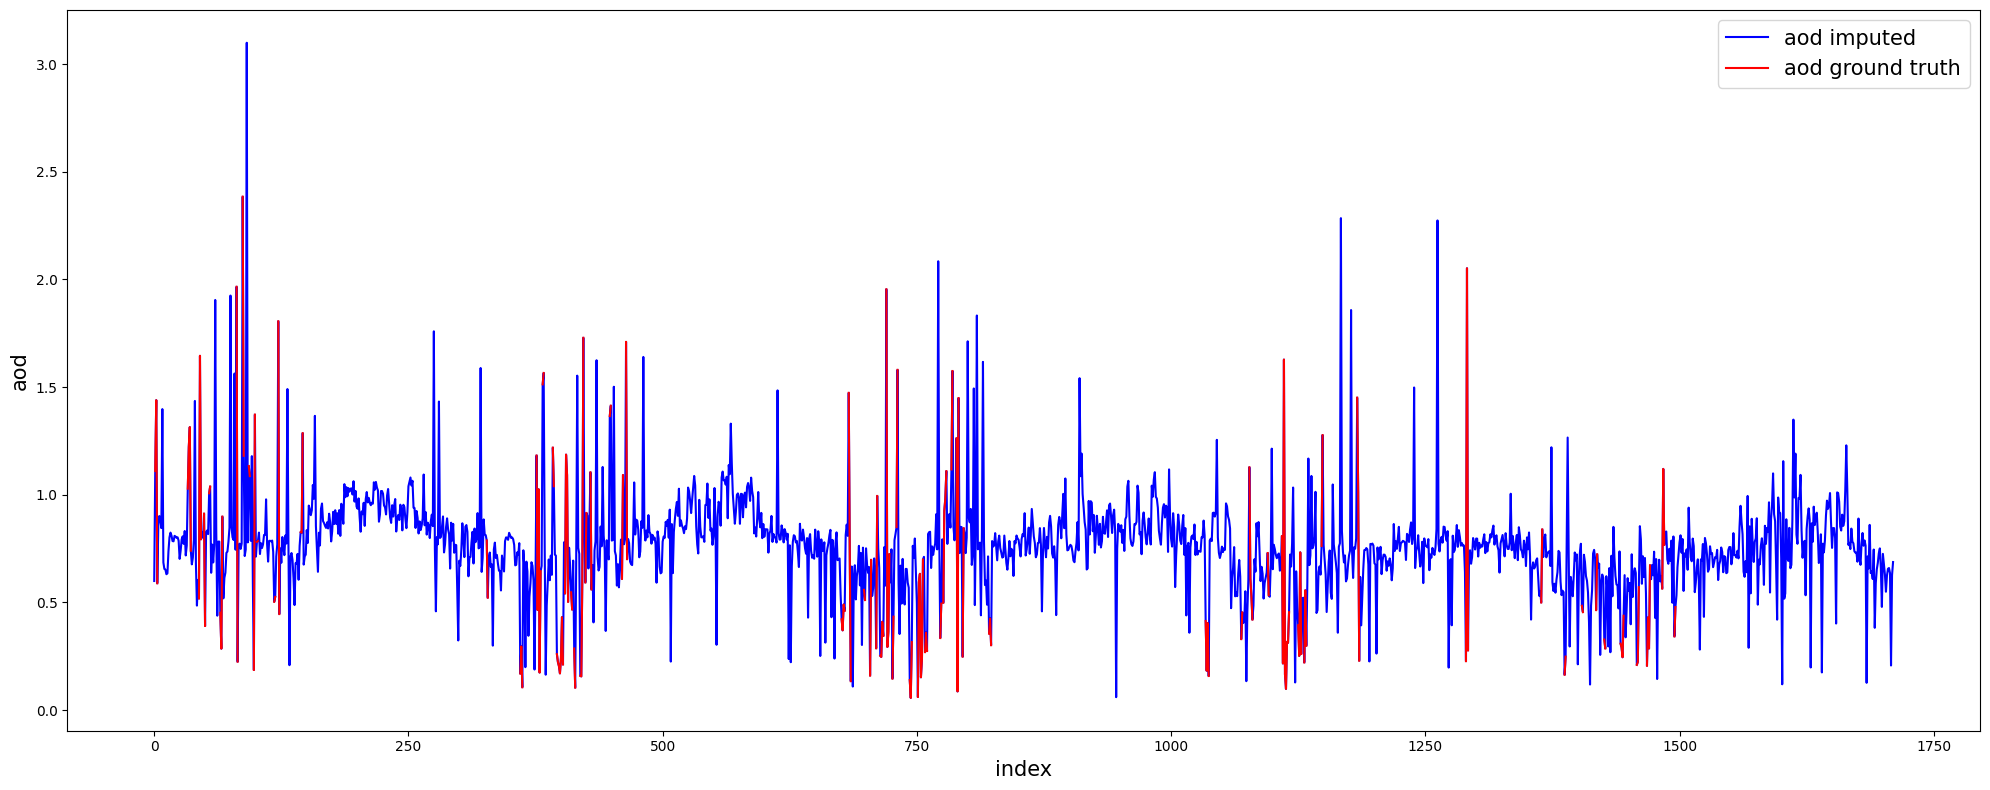


Handling for station 202



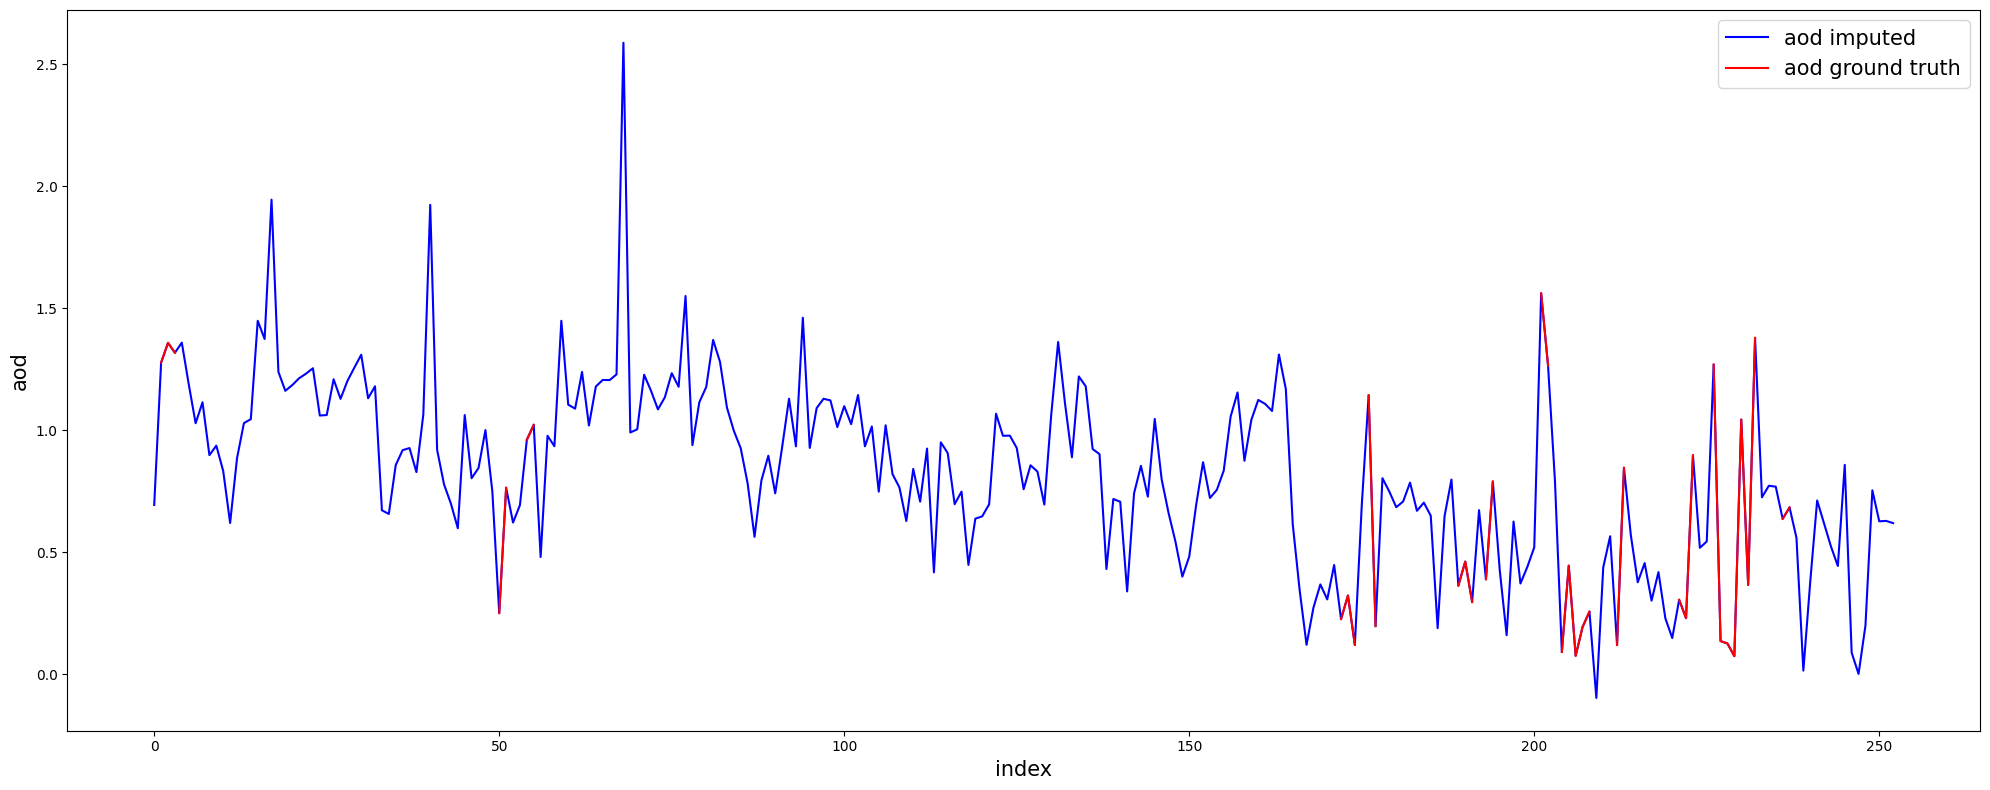


Handling for station 211



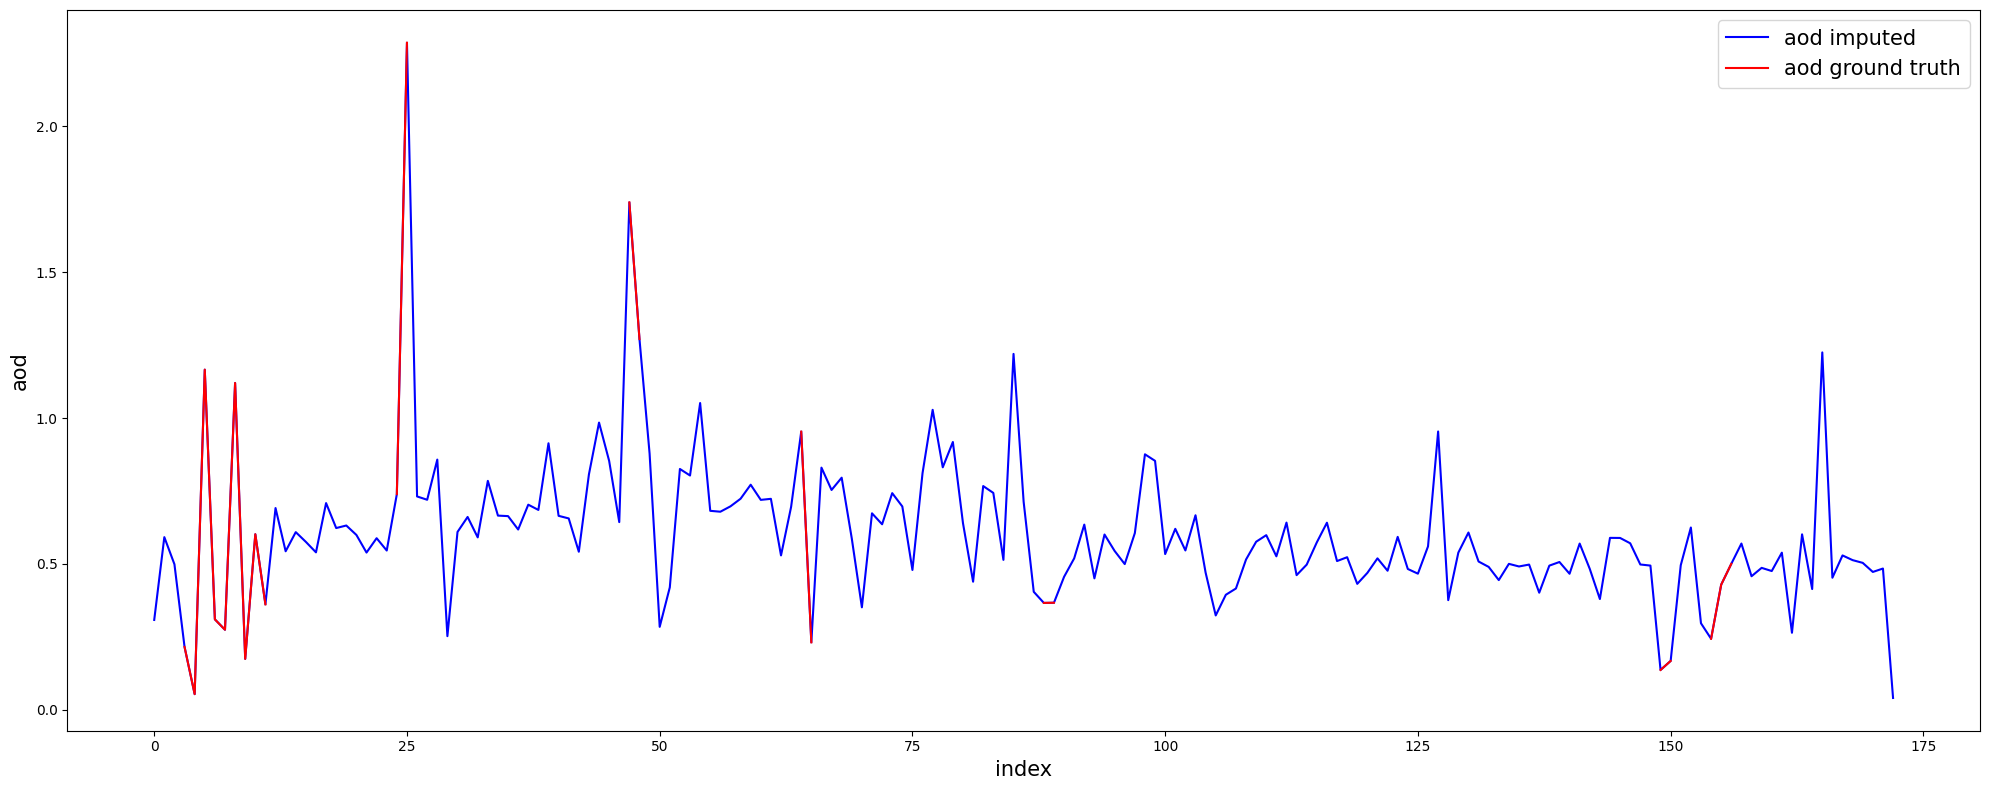


Handling for station 212



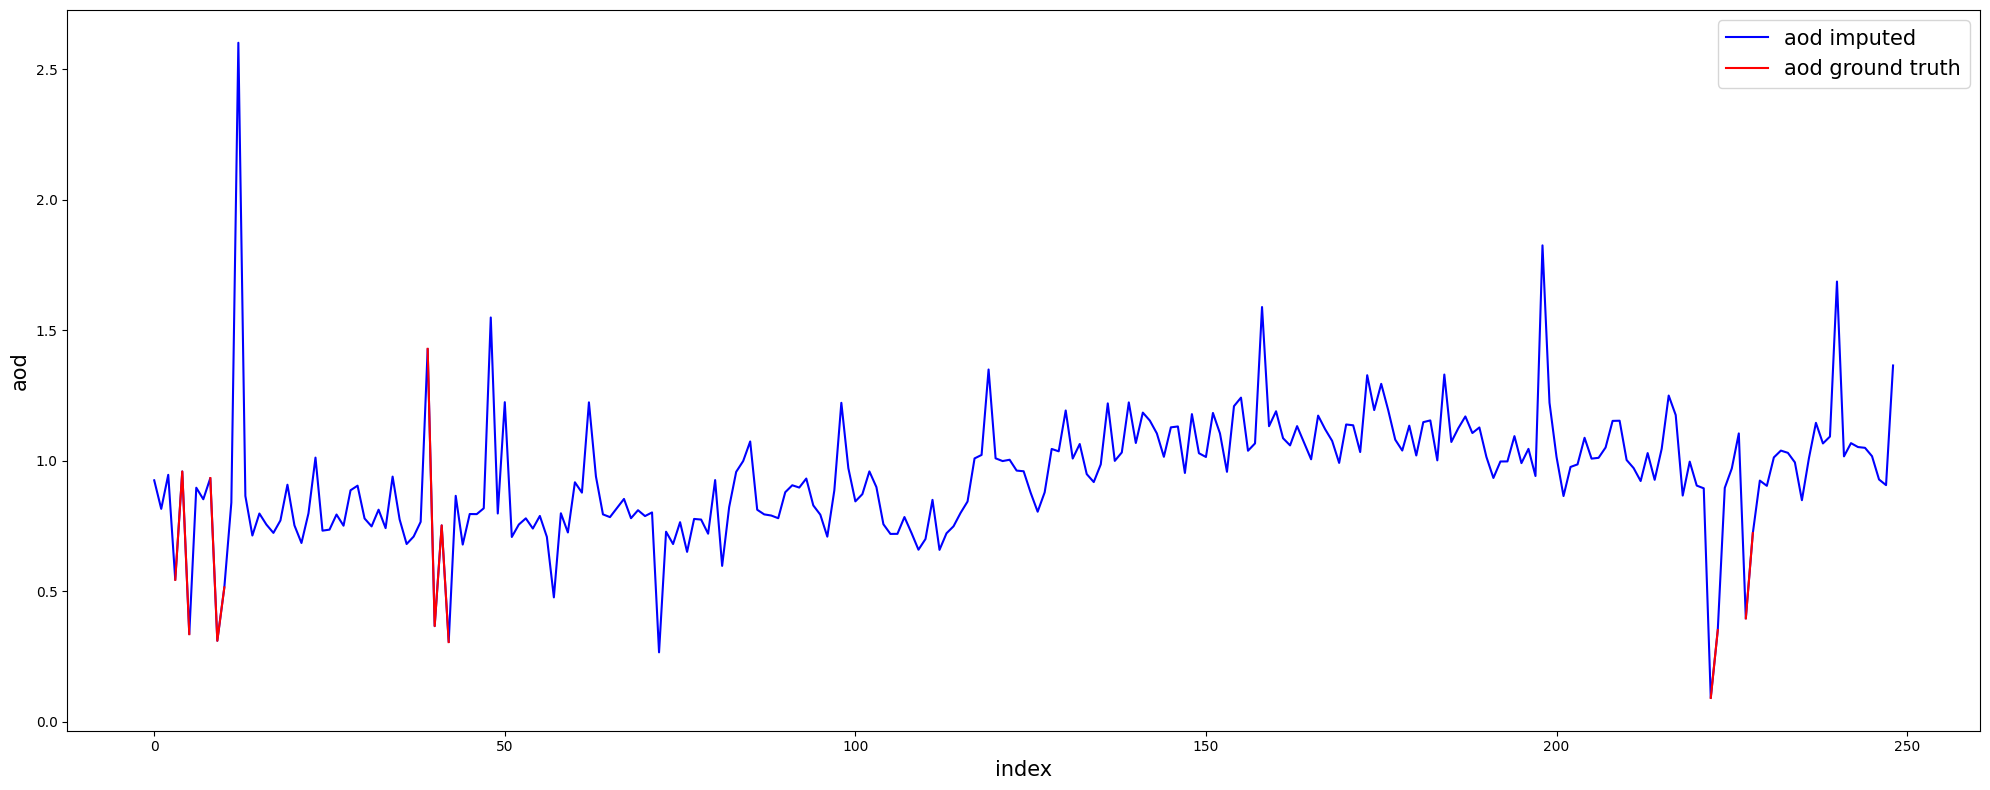


Handling for station 213



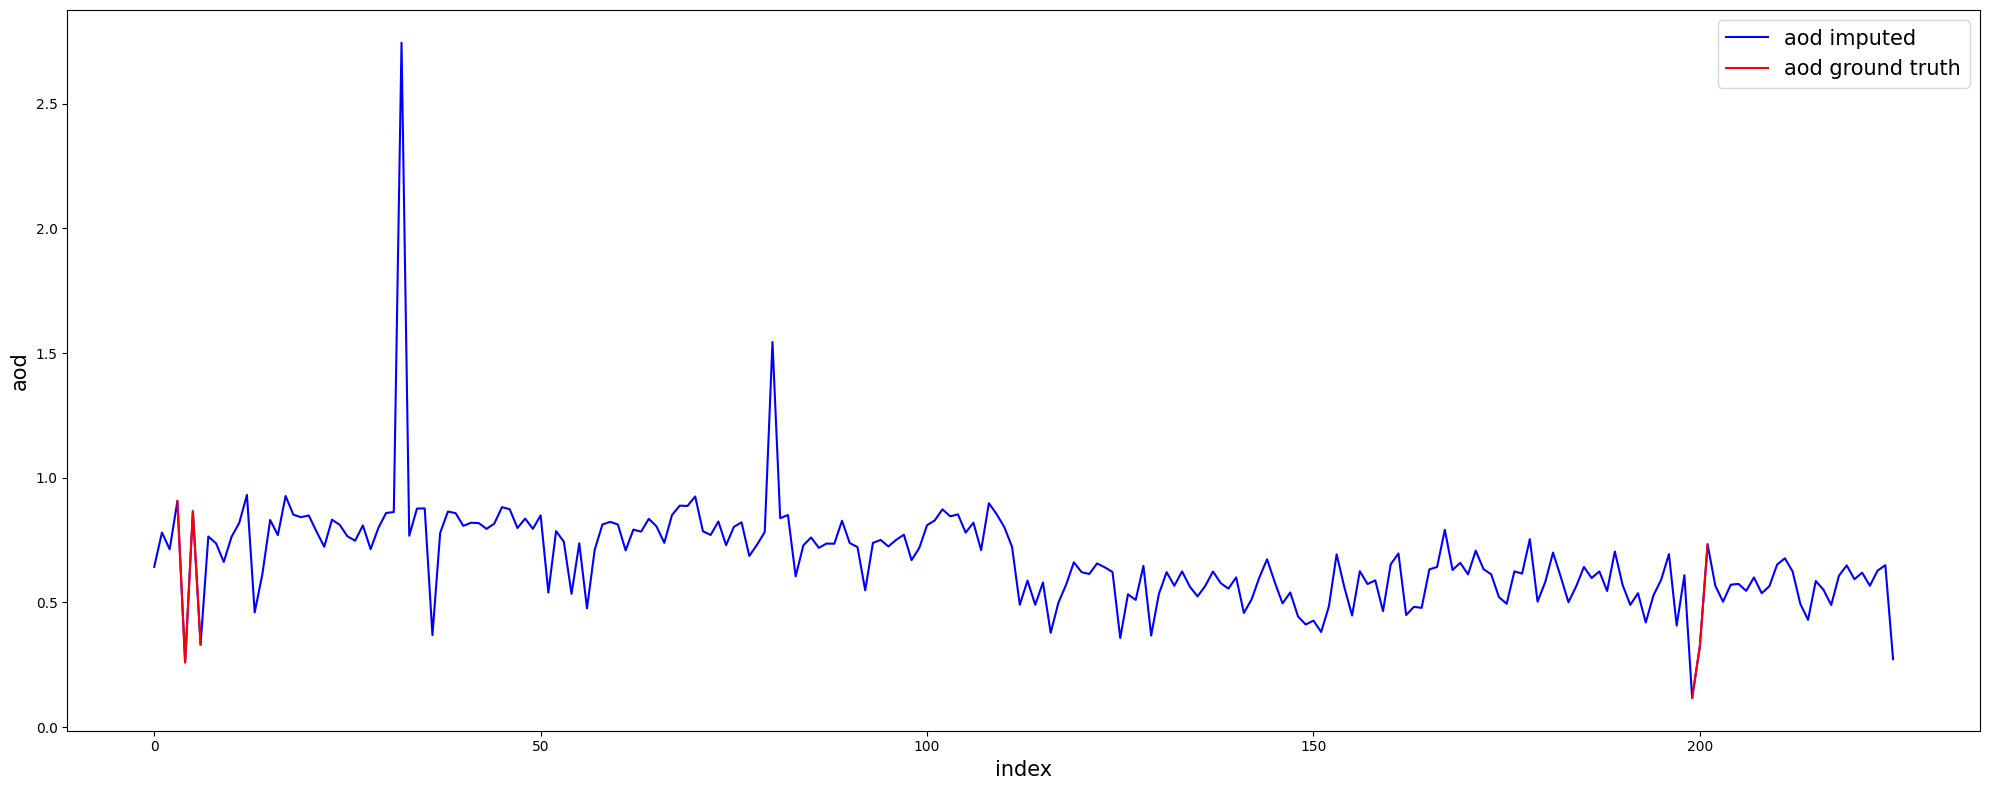


Handling for station 214



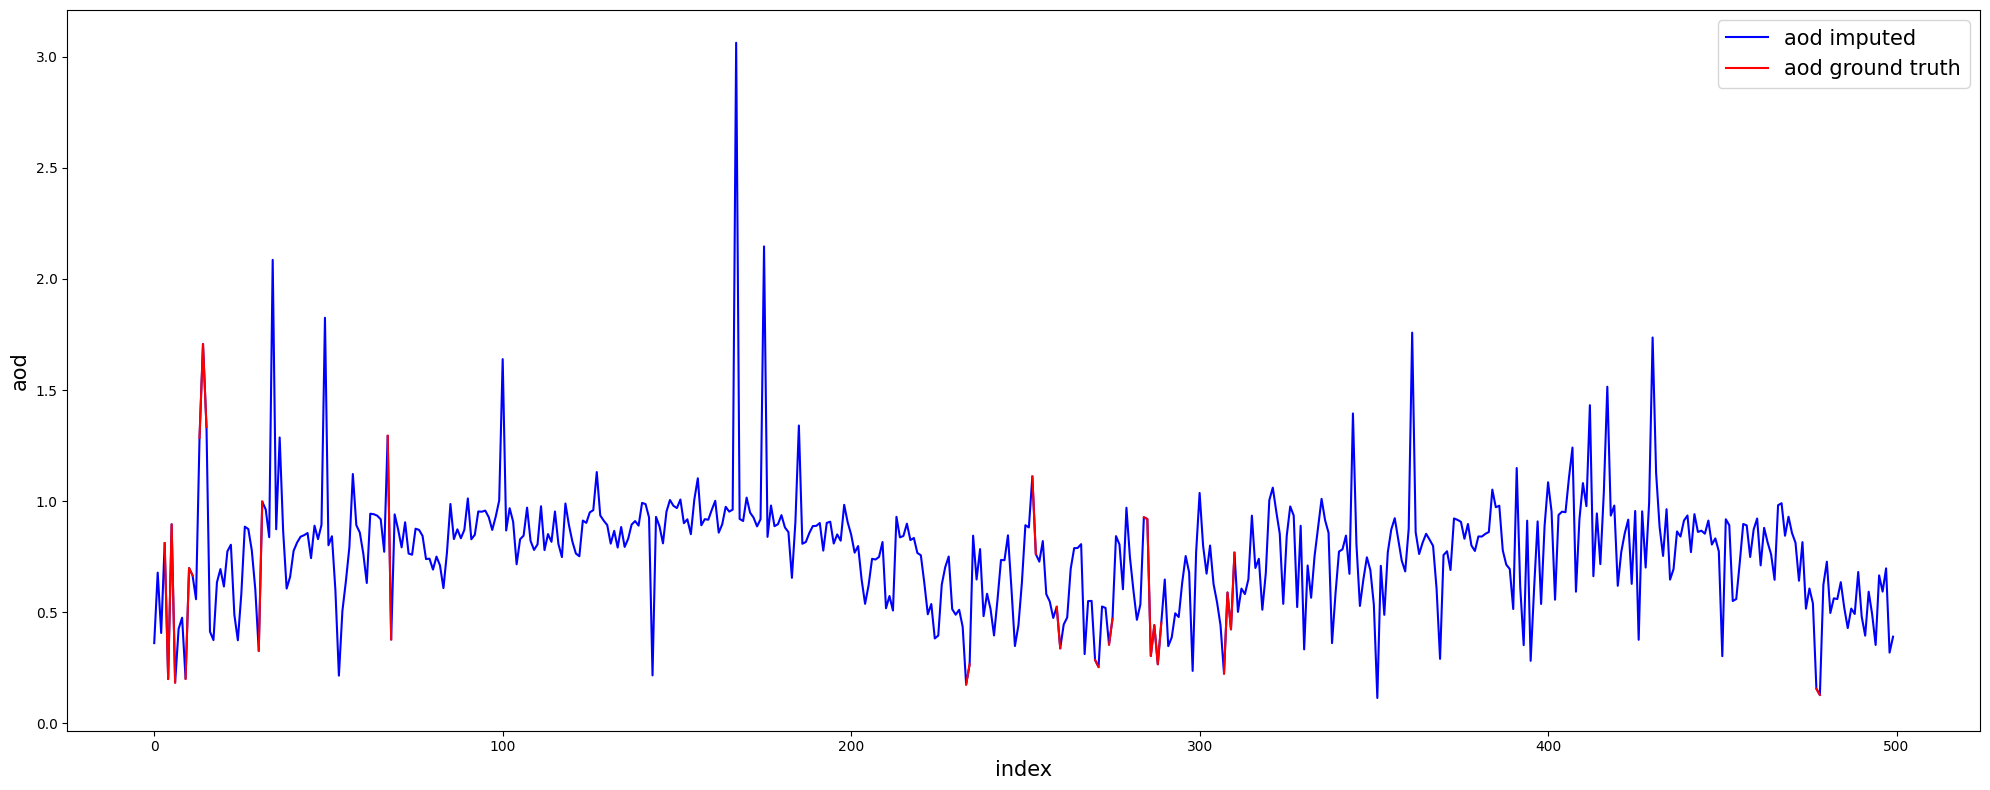


Handling for station 215



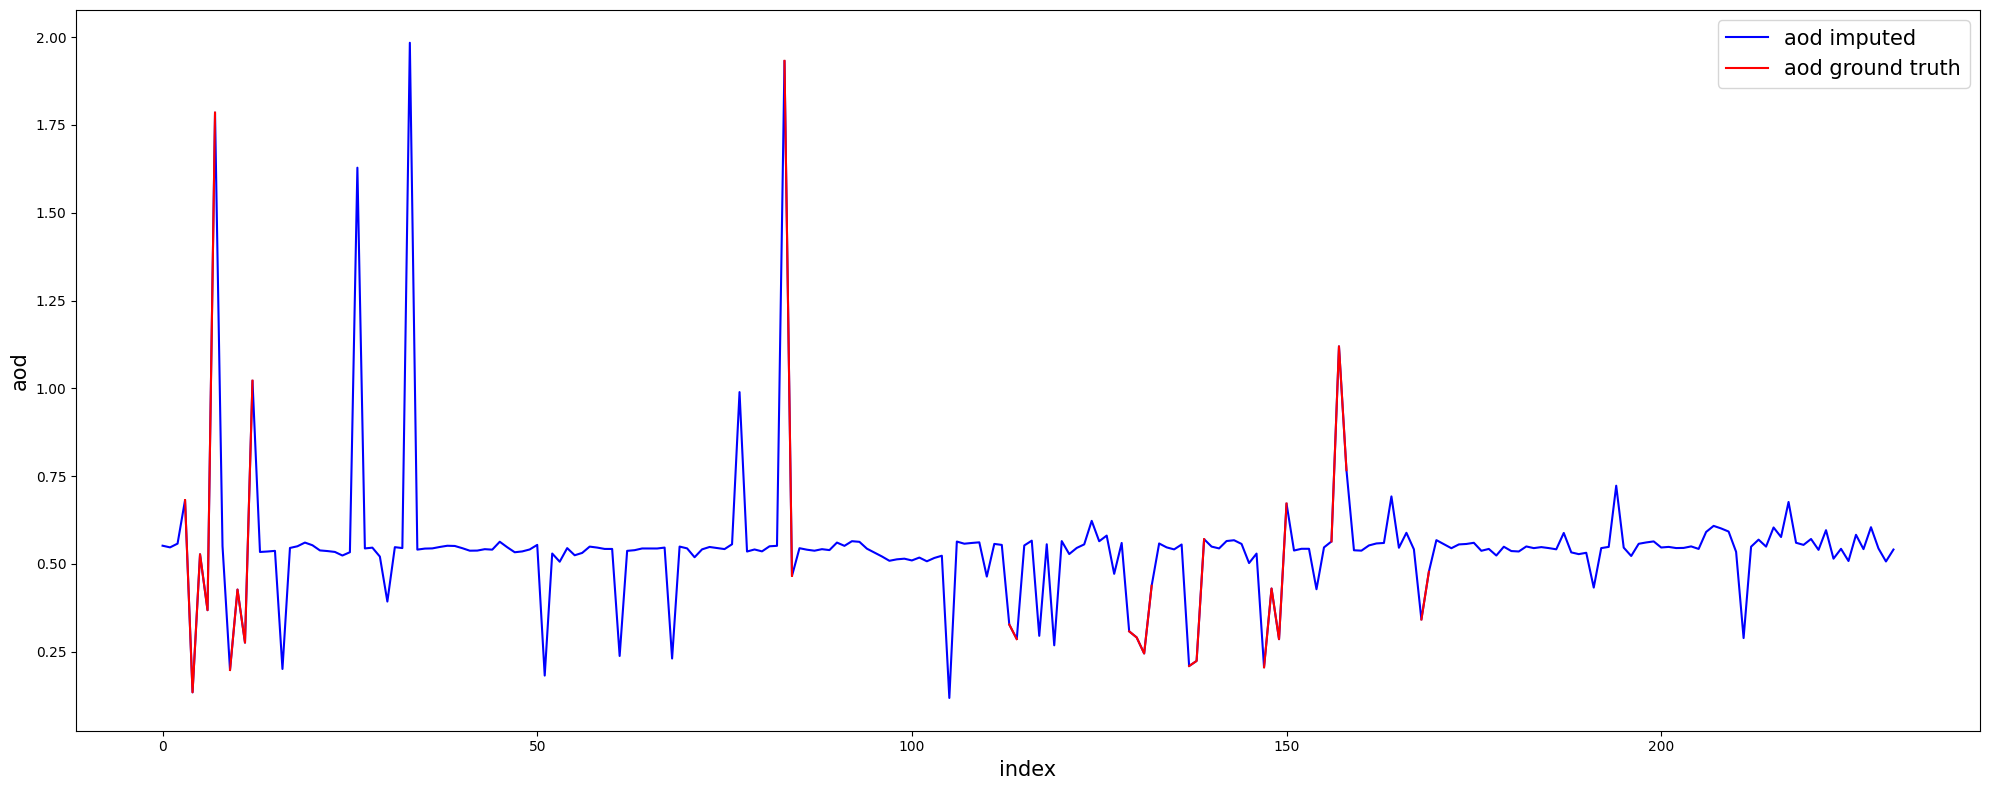


Handling for station 216



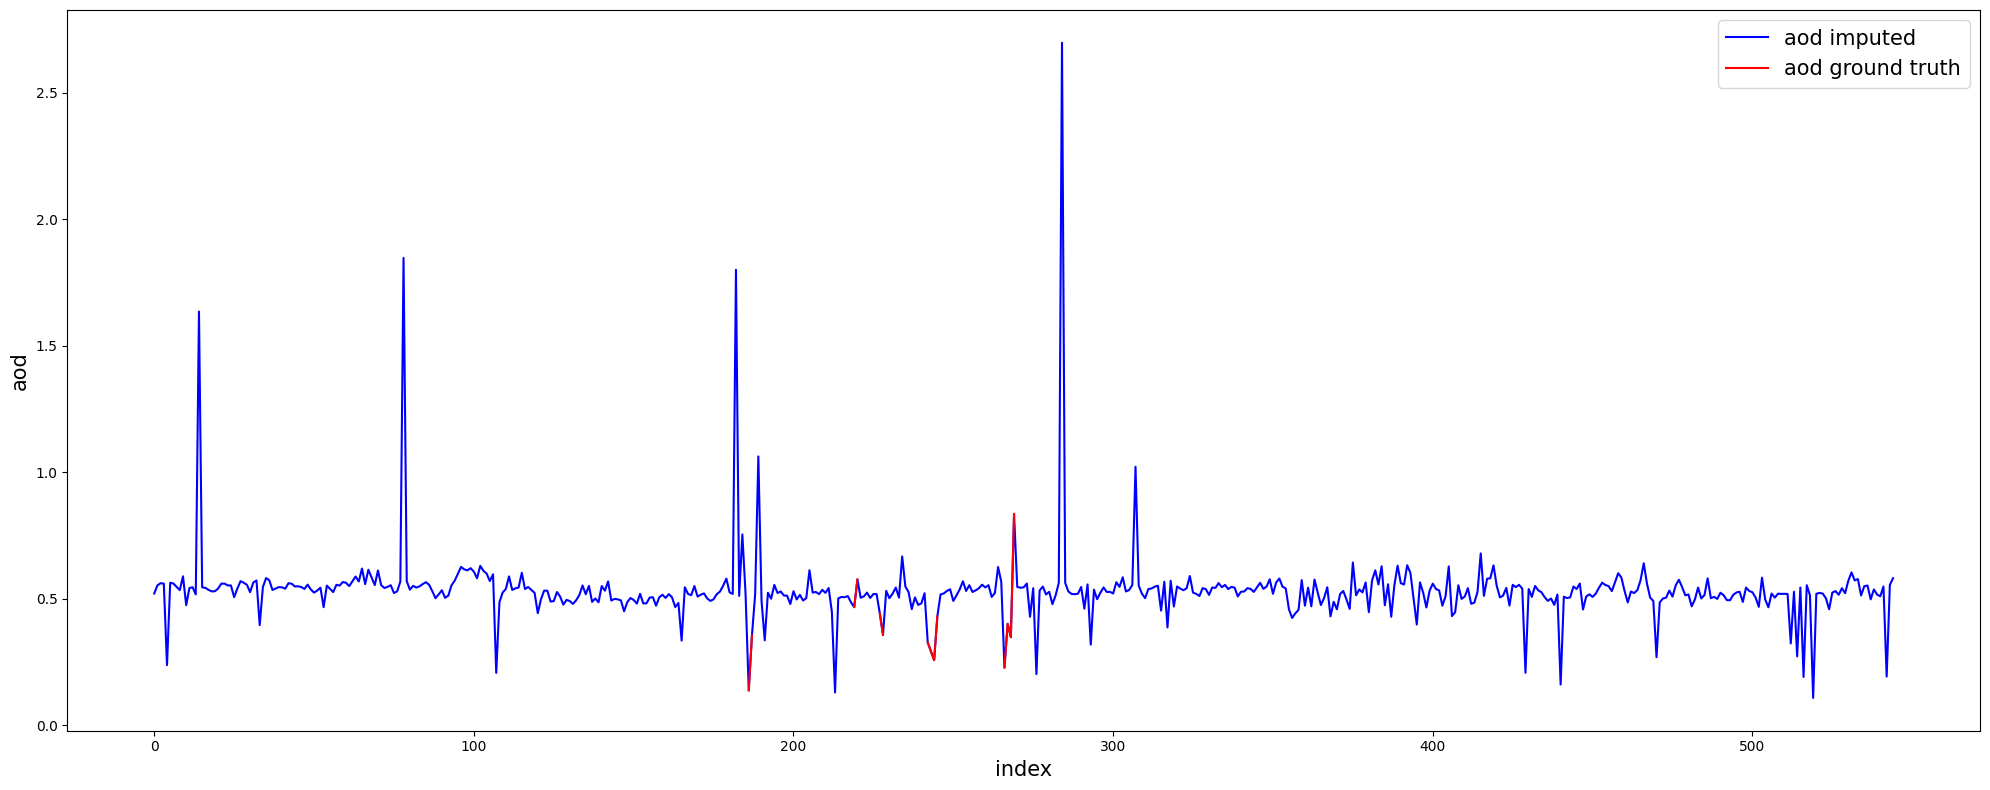

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2018-01-01      201  31.391304  10.783057  106.700606  34.919998  25.204139   
2018-01-02      201  37.458333  10.783057  106.700606  51.830002  24.726431   
2018-01-03      201  68.083333  10.783057  106.700606  38.240002  26.095087   
2018-01-04      201  51.260870  10.783057  106.700606  40.259998  26.514926   
2018-01-05      201  18.909091  10.783057  106.700606  21.690001  25.483535   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2018-01-01  70.056728  455.131335  2.352895  20680.62695  ...   
2018-01-02  73.425826  339.083720  1.903761  20680.62695  ...   
2018-01-03  77.793432  367.190738  1.293329  20680.62695  ...   
2018-01-04  82.982475  462.504210  1.588872  20680.62695  ...   
2018-01-05  93.046504  324.735356  2.505876  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2018-01-01  1876.639945  232011.95950    0.0  2700.122924  0.599173  
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  1.110117  
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  1.439045  
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  0.588595  
2018-01-05  1876.639945  232011.95950    0.0  2700.122924  0.852506  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505  

[3889 rows x 21 columns]

In [72]:
all_stations_df = []

for station in aod_all_stations:
    print(f"\nHandling for station {station}\n")
    # Get dataframe of current station
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]

    # Fill "aod" column
    df_aod_current_station_imputed = copy.deepcopy(df_aod_current_station)
    df_aod_current_station_imputed.loc[:, "aod"] = mice(df_aod_current_station_imputed.drop(columns=["station", "pm25"]))["aod"]
    plot_2_data(data1=df_aod_current_station_imputed["aod"],
               datalabel1="aod imputed",
               data2=df_aod_current_station["aod"],
               datalabel2="aod ground truth",
               ylabel="aod",
               xlabel="index")

    # Store file for debugging after filling missing values
    df_aod_current_station_imputed.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station_imputed)

# Merge all stations
df_aod = pd.concat(all_stations_df)
df_aod

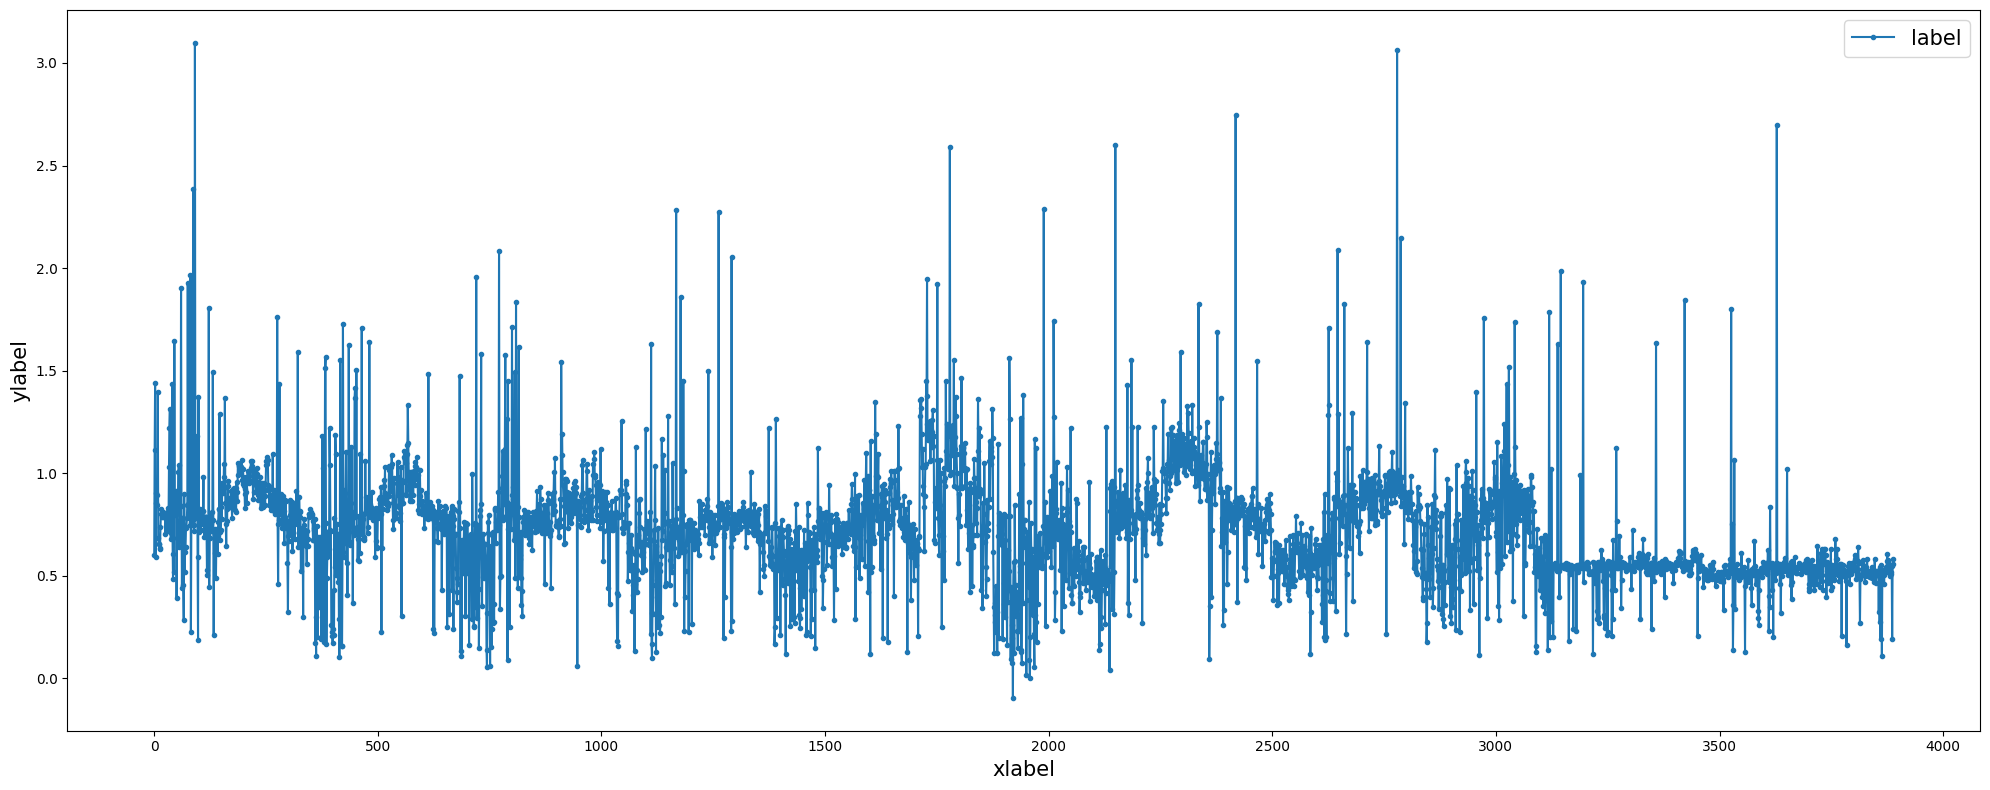

In [73]:
plot_1_data(df_aod["aod"])

In [74]:
df_aod.to_csv('df_aod.csv', index=True)

### Extract columns: time, stations, pm25_3km

In [75]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=3889, freq=None)

In [76]:
# Get the station column
aod_station_column = df_aod.loc[:, "station"]
aod_station_column

time
2018-01-01    201
2018-01-02    201
2018-01-03    201
2018-01-04    201
2018-01-05    201
             ... 
2022-12-27    216
2022-12-28    216
2022-12-29    216
2022-12-30    216
2022-12-31    216
Name: station, Length: 3889, dtype: int64

In [77]:
# Get the pm25_3km column
aod_pm25_3km_column = df_aod.loc[:, "pm25_3km"]
aod_pm25_3km_column

time
2018-01-01    34.919998
2018-01-02    51.830002
2018-01-03    38.240002
2018-01-04    40.259998
2018-01-05    21.690001
                ...    
2022-12-27    34.439411
2022-12-28    29.838476
2022-12-29    28.450829
2022-12-30    19.854403
2022-12-31    27.658358
Name: pm25_3km, Length: 3889, dtype: float64

### Split into features and labels
* Label: pm25
* Features: other columns
    * Dynamic features
    * Static features

In [78]:
# Features with pm25_3km
aod_feats = aod_stat_feats + aod_dyn_feats

# Predict without "station" as a feature
# Remove "pm25_3km" also
aod_feats.remove("station")
aod_feats.remove("pm25_3km")
X_aod = df_aod.loc[:, aod_feats]

# Label
y_aod = df_aod.loc[:, aod_label]

In [79]:
X_aod

lat         lon          pop  road_den_1km  \
time                                                           
2018-01-01  10.783057  106.700606  20680.62695     27.462461   
2018-01-02  10.783057  106.700606  20680.62695     27.462461   
2018-01-03  10.783057  106.700606  20680.62695     27.462461   
2018-01-04  10.783057  106.700606  20680.62695     27.462461   
2018-01-05  10.783057  106.700606  20680.62695     27.462461   
...               ...         ...          ...           ...   
2022-12-27  10.780482  106.659511  57523.91406     33.629780   
2022-12-28  10.780482  106.659511  57523.91406     33.629780   
2022-12-29  10.780482  106.659511  57523.91406     33.629780   
2022-12-30  10.780482  106.659511  57523.91406     33.629780   
2022-12-31  10.780482  106.659511  57523.91406     33.629780   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  \
time                                                                  
2018-01-01  1876.639945  232011.95950    0.0  2700.122924  0.599173   
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  1.110117   
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  1.439045   
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  0.588595   
2018-01-05  1876.639945  232011.95950    0.0  2700.122924  0.852506   
...                 ...           ...    ...          ...       ...   
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564   
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594   
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691   
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055   
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505   

                  hpbl      wspd         rh        tmp  
time                                                    
2018-01-01  455.131335  2.352895  70.056728  25.204139  
2018-01-02  339.083720  1.903761  73.425826  24.726431  
2018-01-03  367.190738  1.293329  77.793432  26.095087  
2018-01-04  462.504210  1.588872  82.982475  26.514926  
2018-01-05  324.735356  2.505876  93.046504  25.483535  
...                ...       ...        ...        ...  
2022-12-27  457.798645  2.002987  73.973083  24.136936  
2022-12-28  644.974548  2.298220  65.530487  25.844296  
2022-12-29  825.517395  2.823764  67.093735  25.841156  
2022-12-30  680.533081  3.893373  64.868401  24.979719  
2022-12-31  799.122803  4.161542  62.377899  25.364861  

[3889 rows x 18 columns]

In [80]:
y_aod

pm25
time                 
2018-01-01  31.391304
2018-01-02  37.458333
2018-01-03  68.083333
2018-01-04  51.260870
2018-01-05  18.909091
...               ...
2022-12-27  39.659816
2022-12-28  44.679352
2022-12-29  30.724708
2022-12-30  33.091428
2022-12-31  28.854069

[3889 rows x 1 columns]

### Data normalization

In [81]:
# Scaled features
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

lat       lon       pop  road_den_1km  prim_road_len_1km  \
0     0.326794  0.466551  0.116512      0.471552           0.949821   
1     0.326794  0.466551  0.116512      0.471552           0.949821   
2     0.326794  0.466551  0.116512      0.471552           0.949821   
3     0.326794  0.466551  0.116512      0.471552           0.949821   
4     0.326794  0.466551  0.116512      0.471552           0.949821   
...        ...       ...       ...           ...                ...   
3884  0.306899  0.237227  0.857395      0.785926           0.323578   
3885  0.306899  0.237227  0.857395      0.785926           0.323578   
3886  0.306899  0.237227  0.857395      0.785926           0.323578   
3887  0.306899  0.237227  0.857395      0.785926           0.323578   
3888  0.306899  0.237227  0.857395      0.785926           0.323578   

      near_dist  bareland   builtup  cropland  grassland  treecover  water  \
0      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
1      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
2      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
3      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
4      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
...         ...       ...       ...       ...        ...        ...    ...   
3884   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3885   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3886   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3887   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3888   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   

          ndvi       aod      hpbl      wspd        rh       tmp  
0     0.526821  0.217912  0.300502  0.170694  0.468797  0.342735  
1     0.526821  0.377783  0.211553  0.110646  0.543165  0.303640  
2     0.526821  0.480703  0.233097  0.029033  0.639575  0.415649  
3     0.526821  0.214603  0.306153  0.068546  0.754117  0.450008  
4     0.526821  0.297179  0.200556  0.191147  0.976269  0.365600  
...        ...       ...       ...       ...       ...       ...  
3884  0.085003  0.189562  0.302546  0.123912  0.555246  0.255396  
3885  0.085003  0.201774  0.446013  0.163384  0.368885  0.395124  
3886  0.085003  0.090414  0.584396  0.233647  0.403392  0.394867  
3887  0.085003  0.203795  0.473268  0.376650  0.354270  0.324368  
3888  0.085003  0.212071  0.564165  0.412504  0.299295  0.355888  

[3889 rows x 18 columns]

In [82]:
# Scaled label
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

pm25
0     0.325673
1     0.398696
2     0.767302
3     0.564825
4     0.175435
...        ...
3884  0.425193
3885  0.485609
3886  0.317649
3887  0.346136
3888  0.295134

[3889 rows x 1 columns]

In [83]:
pd.concat((X_aod_scaled, y_aod_scaled), axis=1)\
    .set_index(aod_time_indices)\
    .to_csv(os.path.join(conf["workspace"]["data_to_store_in_hdfs_dir"], "vientham_2018_2022_before_dim_reduction.csv"))

## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25 as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [84]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction': []} | {m: [] for m in LSTMPrediction.get_supported_metrics()}
evaluation_board

{'dim_reduction_method': [],
 'dim_after_reduction': [],
 'prediction': [],
 'mae': [],
 'mse': [],
 'rmse': [],
 'r2': [],
 'mape': [],
 'mnbe': []}

### Model paramaters

In [85]:
#range_of_dimension = range(conf["reduction"]["min_number_of_features"], X_aod_scaled.shape[1])
range_of_dimension = range(14, 16)
print(*range_of_dimension)

reduction_n_past, reduction_n_future = conf["reduction"]["n_past"], conf["reduction"]["n_future"]
reduction_epochs, reduction_batch_size = conf["reduction"]["epochs"], conf["reduction"]["batch_size"]
print(reduction_n_past, reduction_n_future, reduction_epochs, reduction_batch_size)

prediction_n_past, prediction_n_future = conf["prediction"]["n_past"], conf["prediction"]["n_future"]
prediction_epochs, prediction_batch_size = conf["prediction"]["epochs"], conf["prediction"]["batch_size"]
print(prediction_n_past, prediction_n_future, prediction_epochs, prediction_batch_size)

saved_model_plot_dir = conf["workspace"]["saved_model_plot_dir"]
saved_model_weight_dir = conf["workspace"]["saved_model_weight_dir"]
print(saved_model_plot_dir, saved_model_weight_dir)

14 15
7 7 200 128
7 1 200 128
/le_thanh_van_118/workspace/hiep_workspace/saved_model_plot /le_thanh_van_118/workspace/hiep_workspace/saved_model_weight


### Prediction without reduction

LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_no_dim_reduction"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_34 (LSTM)      │ [(None, 64),      │     21,504 │ input_layer_25[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_21    │ (None, 1, 64)     │          0 │ lstm_34[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_35 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_21… │
│                     │                   │            │ lstm_34[0][1],    │
│                     │                   │            │ lstm_34[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 1, 64)     │          0 │ lstm_35[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, 1, 1)      │         65 │ dropout_9[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,593 (213.25 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 0.0745 - val_loss: 0.0226
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0252 - val_loss: 0.0206
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0198 - val_loss: 0.0192
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0190 - val_loss: 0.0185
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - val_loss: 0.0181
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - val_loss: 0.0177
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160 - val_loss: 0.0175
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0146 - val_loss: 0.0173
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0141 - val_loss: 0.0173
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0135 - val_loss: 0.0174
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0126 - val_loss: 0.0179
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0

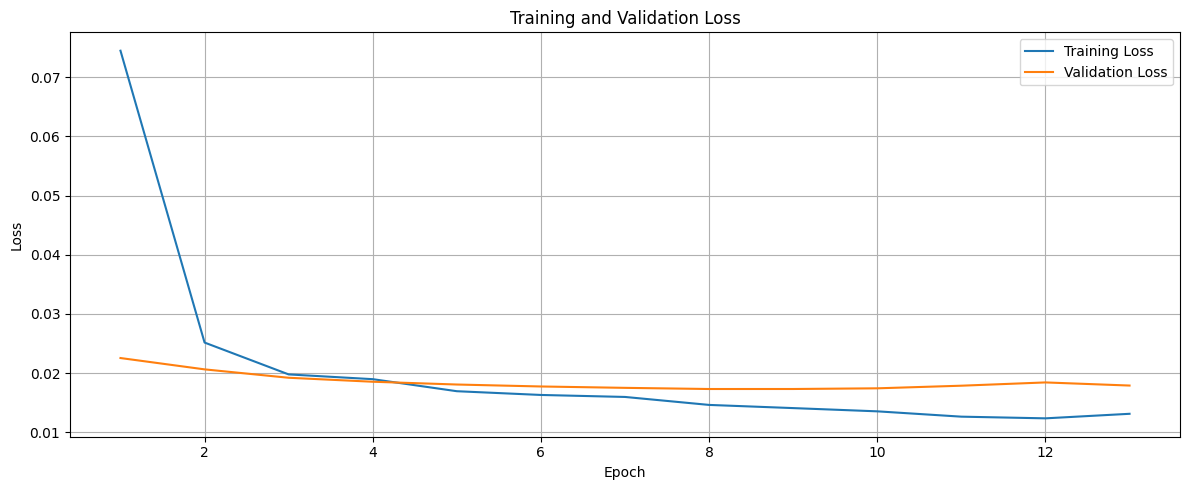

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step 
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Day 1 - mae = 7.554098413015581, mse = 73.25967378319471, r2 = -13.770773068572181, rmse = 8.559186514102535, mape = 0.3223060042978045, mnbe = 31.9389083733251
avg_mae = 7.554098413015581
avg_mse = 73.25967378319471
avg_r2 = -13.770773068572181
avg_rmse = 8.559186514102535
avg_mape = 0.3223060042978045
avg_mnbe = 31.9389083733251
inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


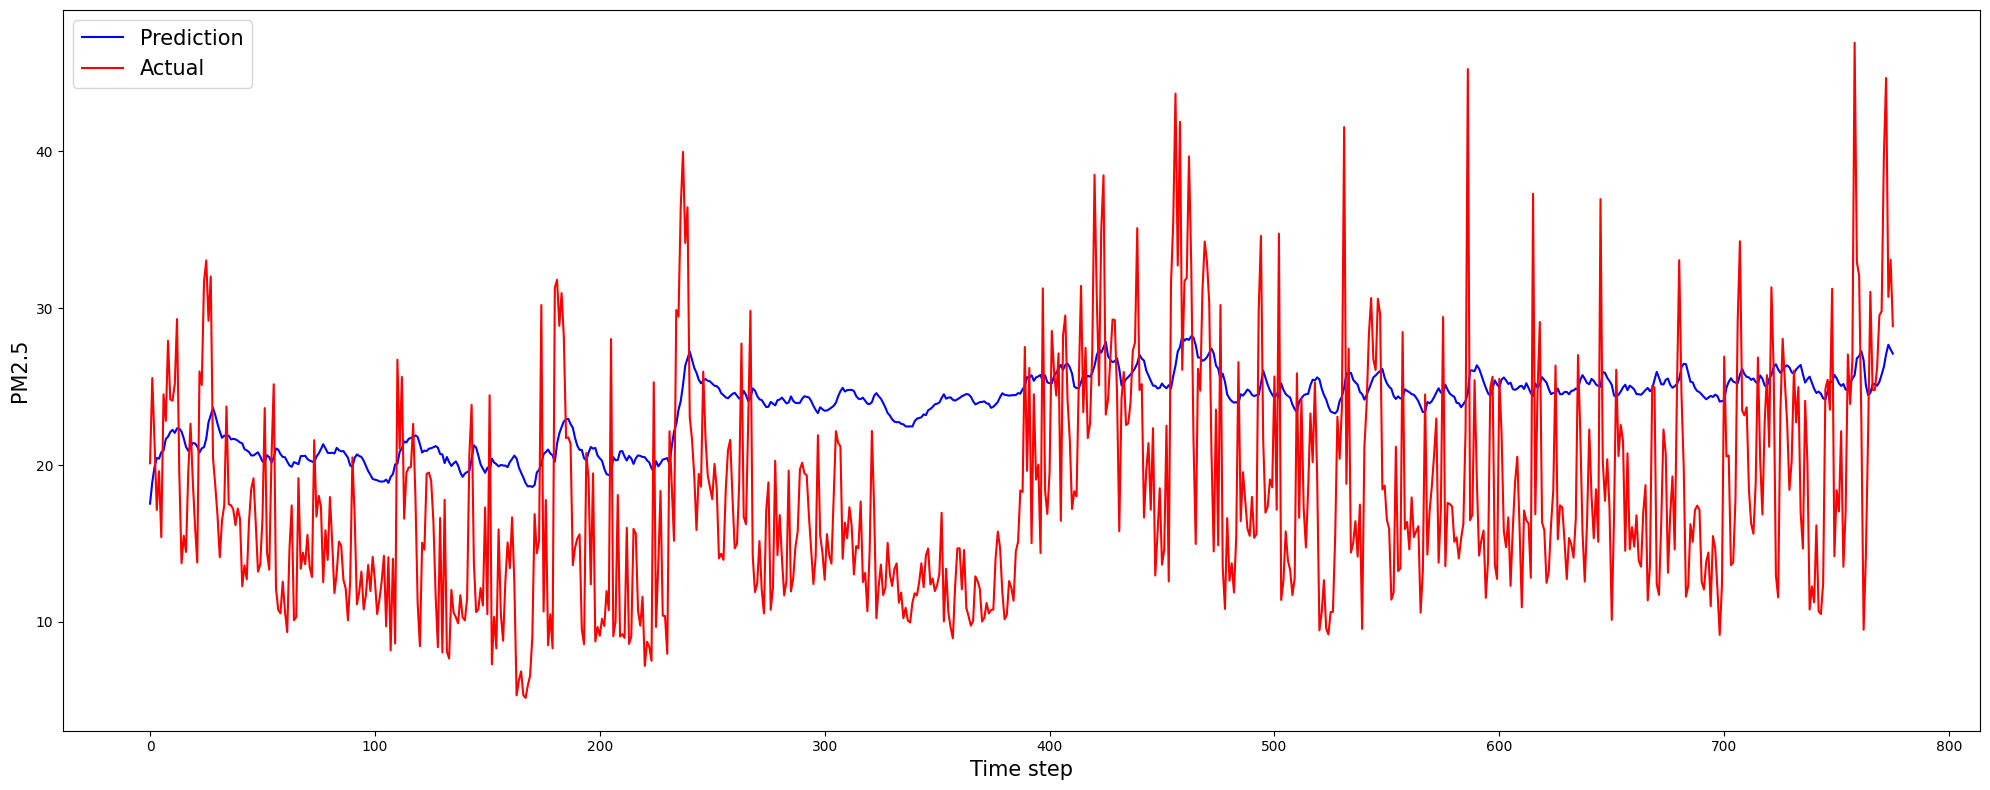

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  7.554098  73.259674   

       rmse         r2      mape       mnbe  
0  8.559187 -13.770773  0.322306  31.938908

In [86]:
# Prediction
lstmpred = LSTMPrediction(X_aod_scaled, y_aod_scaled,
                            aod_label_scaler,
                            val_percentage=0.2, test_percentage=0.2,
                            n_past=prediction_n_past, n_future=prediction_n_future,
                            epochs=prediction_epochs, batch_size=prediction_batch_size,
                            verbose=1,
                            model_name=f"aod_{LSTMPrediction.class_name}_no_dim_reduction")
lstmpred.dump(saved_model_plot_dir)
all_days_inv_y_pred, all_days_inv_y_test, metrics, _ = lstmpred.execute(saved_model_weight_dir)

# Visualize the prediction
plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, prediction_n_future)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["None"]
evaluation_board['dim_after_reduction'] += ["N/A"]
evaluation_board['prediction'] += ["LSTM"]
for m in LSTMPrediction.get_supported_metrics():
    evaluation_board[m] += [metrics[m][1]]
pd.DataFrame(evaluation_board)

### Prediction + LSTM-Seq2Seq

#### Doing the loop

LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 287ms/step - loss: 0.1999 - val_loss: 0.1150
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1099 - val_loss: 0.0978
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0969 - val_loss: 0.0917
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0715 - val_loss: 0.0868
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0625 - val_loss: 0.0782
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0517 - val_loss: 0.0898
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0565 - val_loss: 0.0775
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0458 - val_loss: 0.0707
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1834 - val_loss: 0.0972
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0652 - val_loss: 0.0833
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0517 - val_loss: 0.0737
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/st

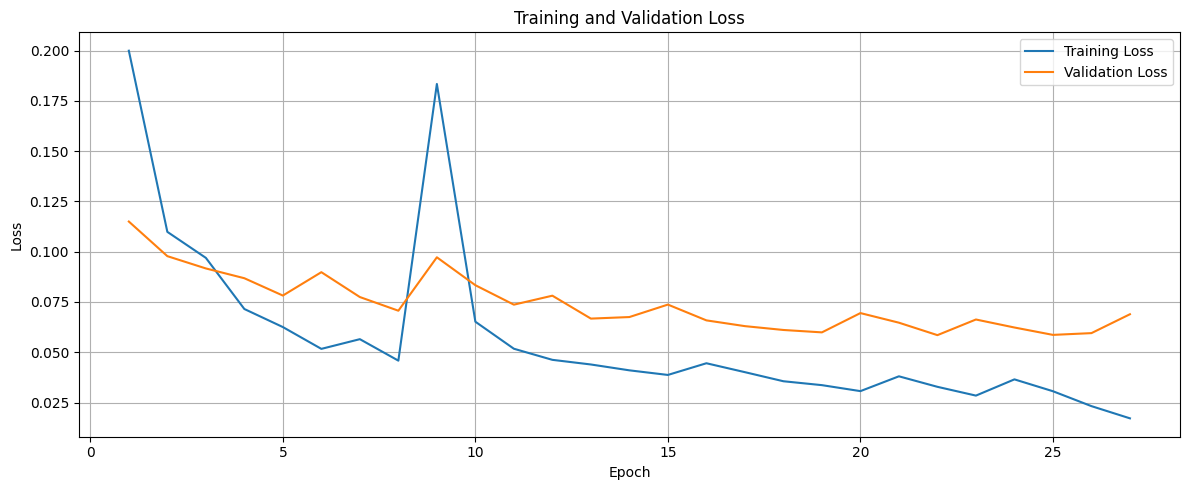

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0458
LSTMSeq2SeqReduction.execute(): mae = 0.045801158994436264
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Model: "aod_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_36[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 14)        │        714 │ lstm_37[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_22    │ (None, 7, 14)     │          0 │ dense_30[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ (None, 7, 50)     │     13,000 │ repeat_vector_22… │
│                     │                   │            │ lstm_37[0][1],    │
│                     │                   │            │ lstm_37[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_38[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, 7, 18)     │      1,818 │ lstm_39[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,198 (1.76 MB)

 Trainable params: 153,732 (600.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,466 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,514 (306.70 KB)

 Trainable params: 78,514 (306.70 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_40 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_28[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_23    │ (None, 1, 64)     │          0 │ lstm_40[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_41 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_23… │
│                     │                   │            │ lstm_40[0][1],    │
│                     │                   │            │ lstm_40[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1, 64)     │          0 │ lstm_41[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, 1, 1)      │         65 │ dropout_10[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0328 - val_loss: 0.0193
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0258 - val_loss: 0.0188
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0213 - val_loss: 0.0192
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0178 - val_loss: 0.0152
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - val_loss: 0.0150
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161 - val_loss: 0.0149
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0158 - val_loss: 0.0146
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0160 - val_loss: 0.0140
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0154 - val_loss: 0.0136
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147 - val_loss: 0.0127
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0140 - val_loss: 0.0121
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 

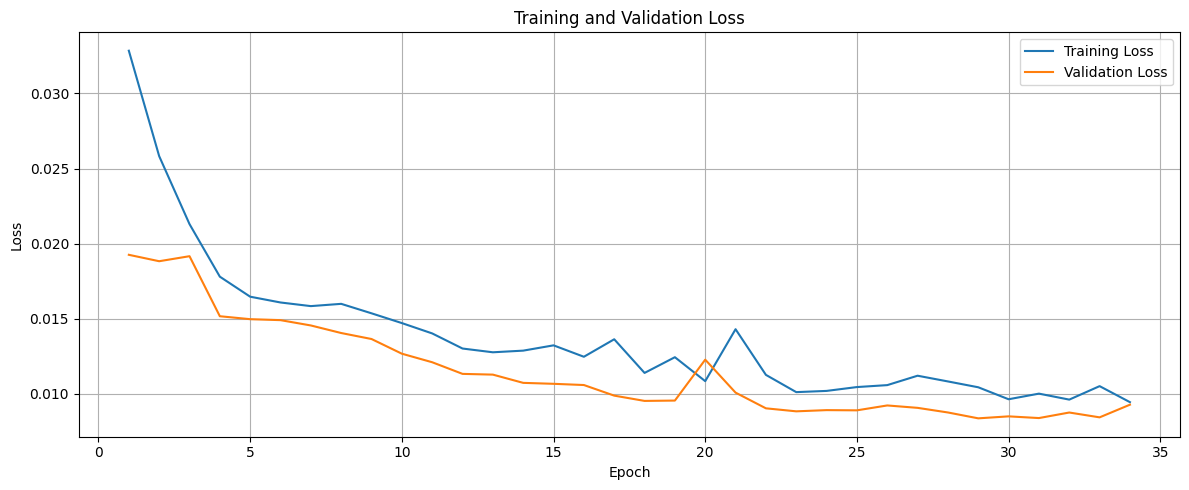

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step 
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Day 1 - mae = 4.886711701557623, mse = 35.676570189472734, r2 = -3.234625654532504, rmse = 5.972986705951448, mape = 0.25690445242355964, mnbe = 7.334277864444956
avg_mae = 4.886711701557623
avg_mse = 35.676570189472734
avg_r2 = -3.234625654532504
avg_rmse = 5.972986705951448
avg_mape = 0.25690445242355964
avg_mnbe = 7.334277864444956
LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 285ms/step - loss: 0.2019 - val_loss: 0.1148
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0964 - val_loss: 0.0993
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0940 - val_loss: 0.0855
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0668 - val_loss: 0.0834
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0600 - val_loss: 0.0781
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0547 - val_loss: 0.0701
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0427 - val_loss: 0.0679
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0352 - val_loss: 0.0536
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0314 - val_loss: 0.0630
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1345 - val_loss: 0.0840
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0620 - val_loss: 0.0815
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/st

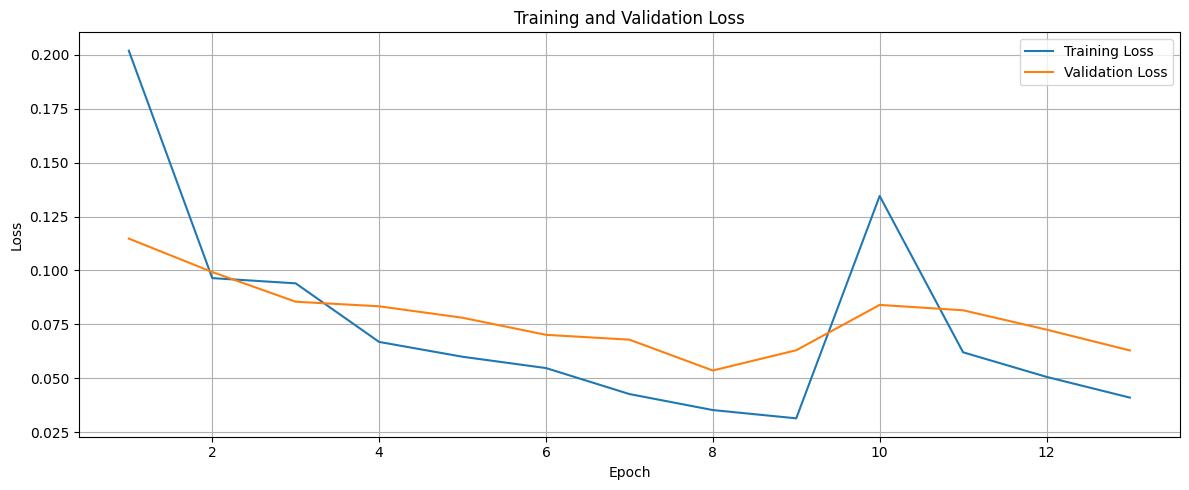

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0447
LSTMSeq2SeqReduction.execute(): mae = 0.04469558596611023
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Model: "aod_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_43 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_42[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 15)        │        765 │ lstm_43[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_24    │ (None, 7, 15)     │          0 │ dense_33[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_44 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_24… │
│                     │                   │            │ lstm_43[0][1],    │
│                     │                   │            │ lstm_43[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_45 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_44[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, 7, 18)     │      1,818 │ lstm_45[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,951 (1.76 MB)

 Trainable params: 153,983 (601.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,968 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,565 (306.89 KB)

 Trainable params: 78,565 (306.89 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_46 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_31[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_25    │ (None, 1, 64)     │          0 │ lstm_46[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_47 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_25… │
│                     │                   │            │ lstm_46[0][1],    │
│                     │                   │            │ lstm_46[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 1, 64)     │          0 │ lstm_47[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, 1, 1)      │         65 │ dropout_11[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 0.0380 - val_loss: 0.0187
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0247 - val_loss: 0.0215
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0244 - val_loss: 0.0164
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0204 - val_loss: 0.0175
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0194 - val_loss: 0.0154
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0176 - val_loss: 0.0150
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - val_loss: 0.0150
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - val_loss: 0.0141
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - val_loss: 0.0130
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0141 - val_loss: 0.0127
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0136 - val_loss: 0.0124
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss:

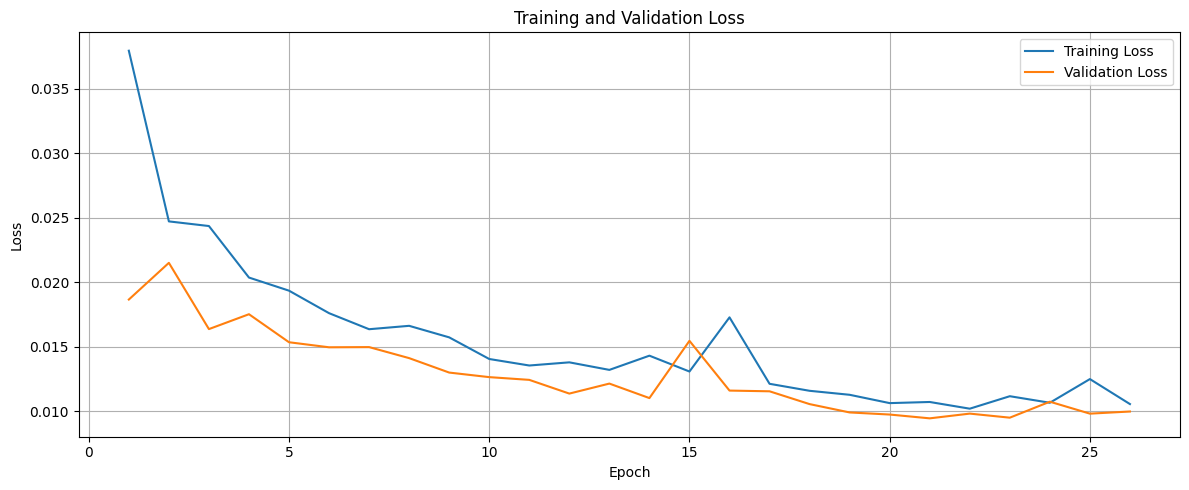

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Day 1 - mae = 5.137927386124955, mse = 37.83309485615417, r2 = -4.1653093901630625, rmse = 6.150861310105616, mape = 0.2637832400160432, mnbe = 9.989192767752492
avg_mae = 5.137927386124955
avg_mse = 37.83309485615417
avg_r2 = -4.1653093901630625
avg_rmse = 6.150861310105616
avg_mape = 0.2637832400160432
avg_mnbe = 9.989192767752492
Choosing the best result

dict_keys([14, 15])
N = 14
mae = 4.886711701557623
mse = 35.676570189472734
rmse = 5.972986705951448
r2 = -3.234625654532504
mape = 0.25690445242355964
mnbe = 7.334277864444956
N = 15
mae = 5.137927386124955
mse = 37.83309485615417
rmse = 6.150861310105616
r2 = -4.1653093901630625
mape = 0.2637832400160432
mnbe = 9.989192767752492


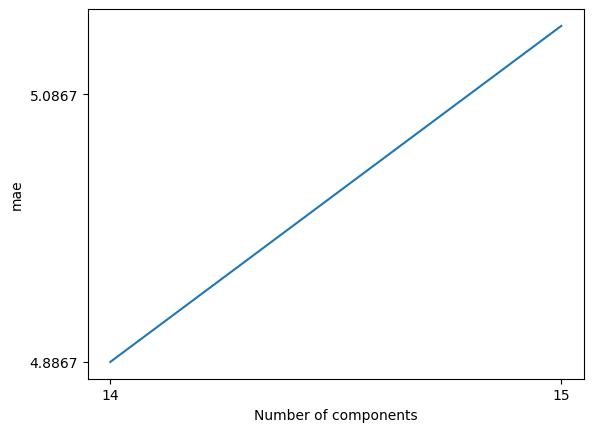

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


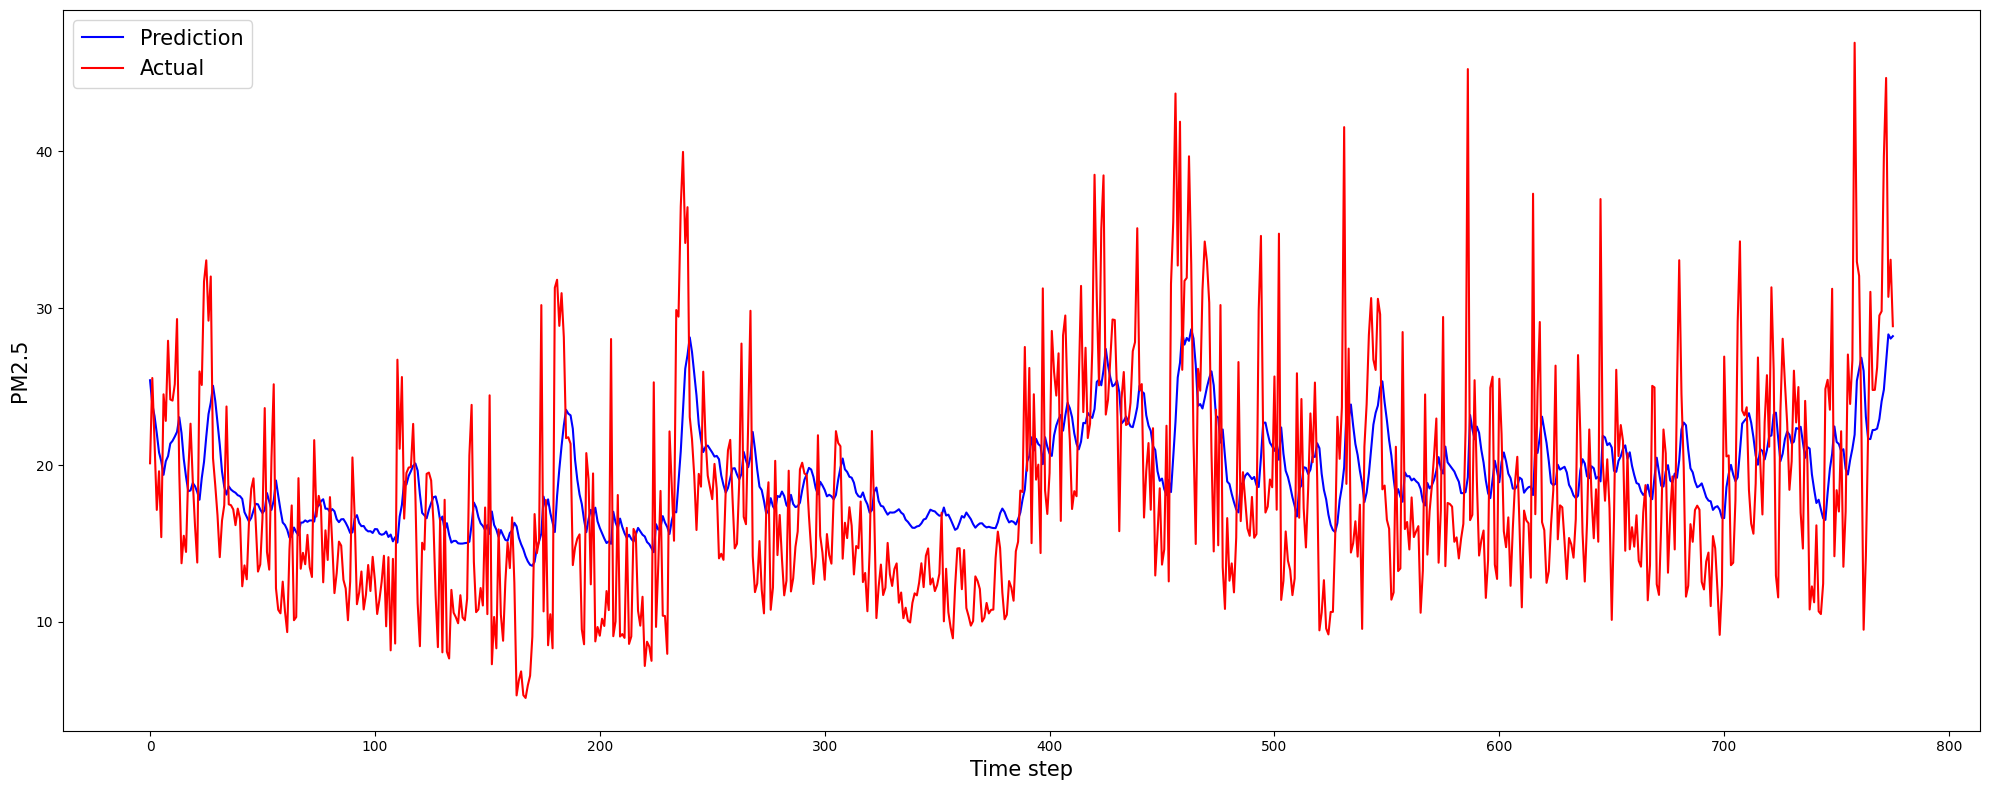

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  7.554098  73.259674   
1         LSTM-Seq2Seq                  14       LSTM  4.886712  35.676570   

       rmse         r2      mape       mnbe  
0  8.559187 -13.770773  0.322306  31.938908  
1  5.972987  -3.234626  0.256904   7.334278

In [87]:
loopresults = generate_loopresults(X_aod_scaled, y_aod_scaled,
                                   aod_label_scaler,
                                   range_of_dimension,
                                   LSTMSeq2SeqReduction,
                                   LSTMPrediction,
                                   reduction_n_past, reduction_n_future,
                                   reduction_epochs, reduction_batch_size,
                                   prediction_n_past, prediction_n_future,
                                   prediction_epochs, prediction_batch_size,
                                   saved_model_weight_dir, saved_model_plot_dir)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [88]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Inference LSTM
pred_pm25_from_df_lstms2s_reduced = inferenceLSTM(best_encoded_data, y_aod_scaled,
                                                    prediction_n_past, prediction_n_future,
                                                    best_prediction_model_path, verbose=1)
inv_pred_pm25_from_df_lstms2s_reduced = aod_label_scaler.inverse_transform(pred_pm25_from_df_lstms2s_reduced.reshape(-1, 1))
print(inv_pred_pm25_from_df_lstms2s_reduced.shape)
print(inv_pred_pm25_from_df_lstms2s_reduced)

# Prepare the reduced data
df_lstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices,
                                        (aod_station_column, "station"),
                                        (inv_pred_pm25_from_df_lstms2s_reduced, "predicted_pm25"),
                                        (aod_pm25_3km_column, "pm25_3km"))
df_lstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data_dir"], "df_lstms2s_reduced_2018_2022.csv"))
df_lstms2s_reduced.to_csv(os.path.join(conf["workspace"]["data_to_store_in_hdfs_dir"], "vientham_2018_2022_reduced_with_lstms2s.csv"))
df_lstms2s_reduced

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
(3889, 1)
[[27.598429]
 [27.598429]
 [28.785456]
 ...
 [28.333265]
 [28.064348]
 [28.218998]]


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.163047      -2.604044       0.028678       0.298322   
2018-01-02       0.163047      -2.604044       0.028678       0.298322   
2018-01-03       0.163708      -2.601390       0.027564       0.298154   
2018-01-04       0.165330      -2.599372       0.026126       0.297282   
2018-01-05       0.167206      -2.602229       0.023794       0.296814   
...                   ...            ...            ...            ...   
2022-12-27       0.272879      -2.043603       0.513575       0.017978   
2022-12-28       0.269774      -2.041911       0.513041       0.019930   
2022-12-29       0.267473      -2.025659       0.513671       0.018630   
2022-12-30       0.266768      -2.019120       0.516159       0.014758   
2022-12-31       0.269087      -2.028699       0.519035       0.012311   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.249012      -0.266178       0.979775      -0.908487   
2018-01-02       0.249012      -0.266178       0.979775      -0.908487   
2018-01-03       0.249563      -0.266464       0.978181      -0.908427   
2018-01-04       0.251703      -0.267364       0.976356      -0.908605   
2018-01-05       0.254346      -0.268522       0.976920      -0.908059   
...                   ...            ...            ...            ...   
2022-12-27       0.277397      -0.468598       0.525131      -0.811342   
2022-12-28       0.276108      -0.467782       0.527113      -0.813002   
2022-12-29       0.273738      -0.466812       0.519790      -0.808541   
2022-12-30       0.275181      -0.467994       0.517804      -0.805006   
2022-12-31       0.278635      -0.471093       0.521433      -0.806786   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       0.718133        0.038356       -1.018988        2.678192   
2018-01-02       0.718133        0.038356       -1.018988        2.678192   
2018-01-03       0.718398        0.037356       -1.018223        2.675920   
2018-01-04       0.718229        0.036395       -1.019446        2.674498   
2018-01-05       0.718872        0.035962       -1.024748        2.678267   
...                   ...             ...             ...             ...   
2022-12-27       0.955001       -0.186581       -0.736648        1.899977   
2022-12-28       0.953752       -0.184653       -0.733380        1.899572   
2022-12-29       0.946751       -0.183920       -0.726910        1.882394   
2022-12-30       0.946459       -0.185701       -0.726849        1.873379   
2022-12-31       0.953368       -0.187639       -0.733271        1.880918   

            aod_feature_13  aod_feature_14  station  predicted_pm25   pm25_3km  
time                                                                            
2018-01-01        0.962215        0.334833      201       27.598429  34.919998  
2018-01-02        0.962215        0.334833      201       27.598429  51.830002  
2018-01-03        0.963163        0.334169      201       28.785456  38.240002  
2018-01-04        0.965365        0.332382      201       35.023121  40.259998  
2018-01-05        0.968689        0.332837      201       37.375778  21.690001  
...                    ...             ...      ...             ...        ...  
2022-12-27        0.448741        0.392878      216       24.805321  34.439411  
2022-12-28        0.449230        0.394062      216       26.537874  29.838476  
2022-12-29        0.443144        0.389132      216       28.333265  28.450829  
2022-12-30        0.440165        0.387777      216       28.064348  19.854403  
2022-12-31        0.441839        0.389712      216       28.218998  27.658358  

[3889 rows x 17 columns]

#### Compare MAE with pm25_3km

On test data:
MAE between actual and pm25_3km: 6.785086281801943
MAE between actual and predicted pm25: 4.886711701557623
MSE between actual and pm25_3km: 87.2793385941348
MSE between actual and predicted pm25: 35.676570189472734


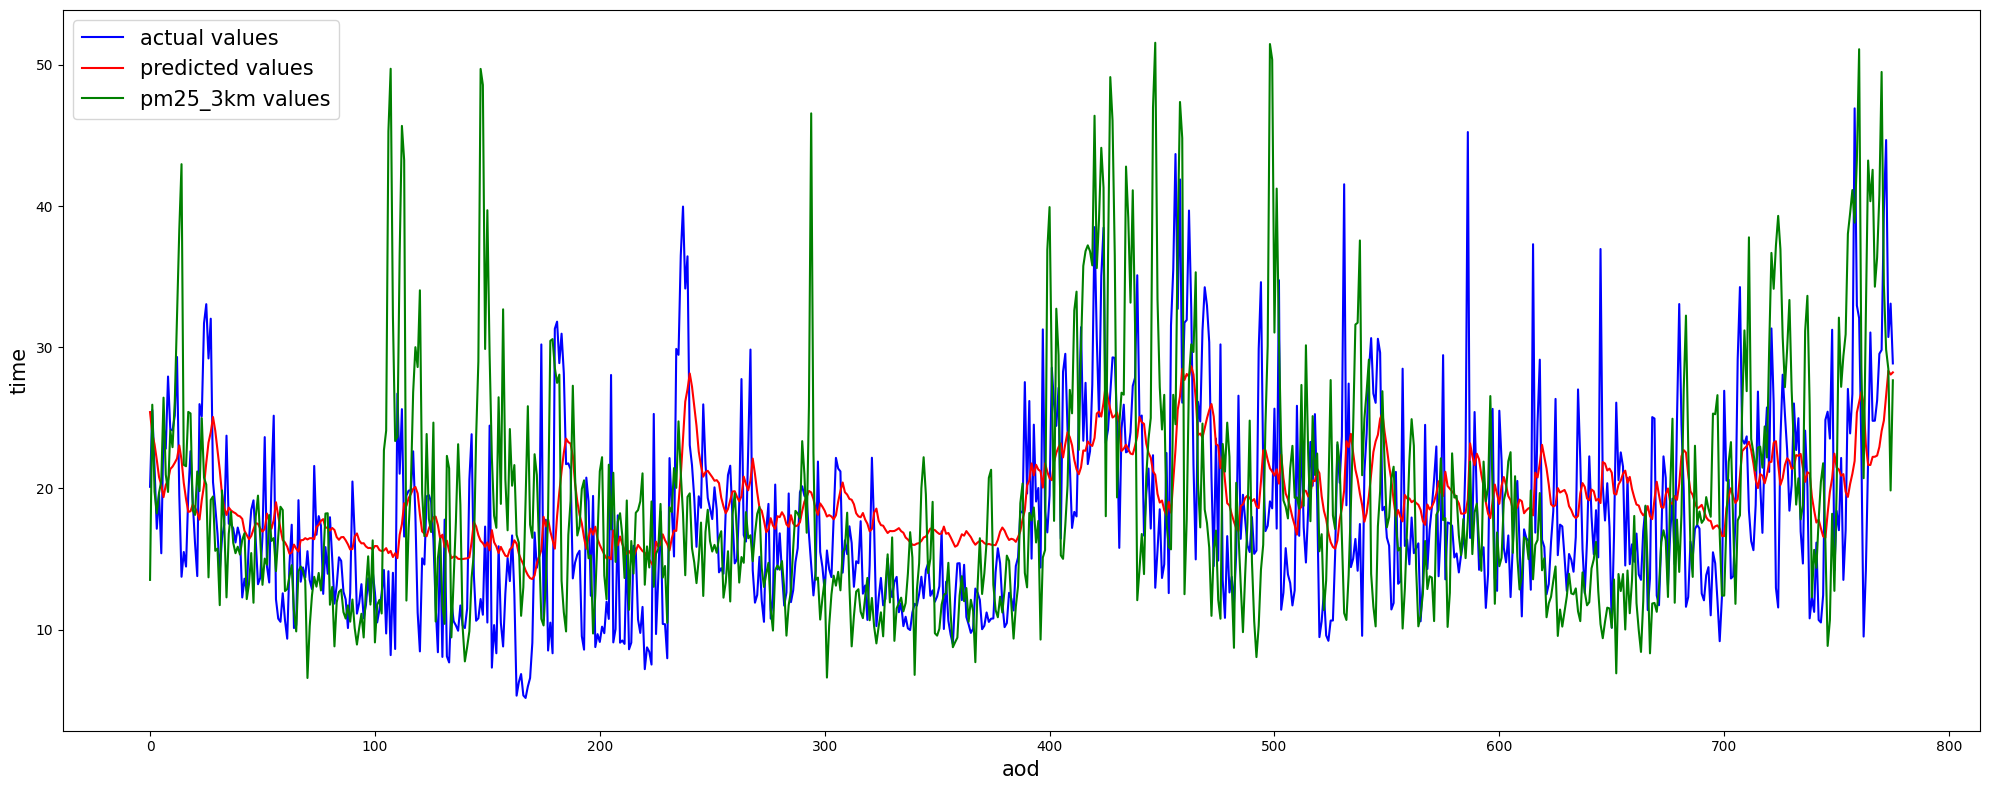

On entire data:
MAE between actual and pm25_3km: 7.875957292759844
MAE between actual and predicted pm25: 5.800497055053711


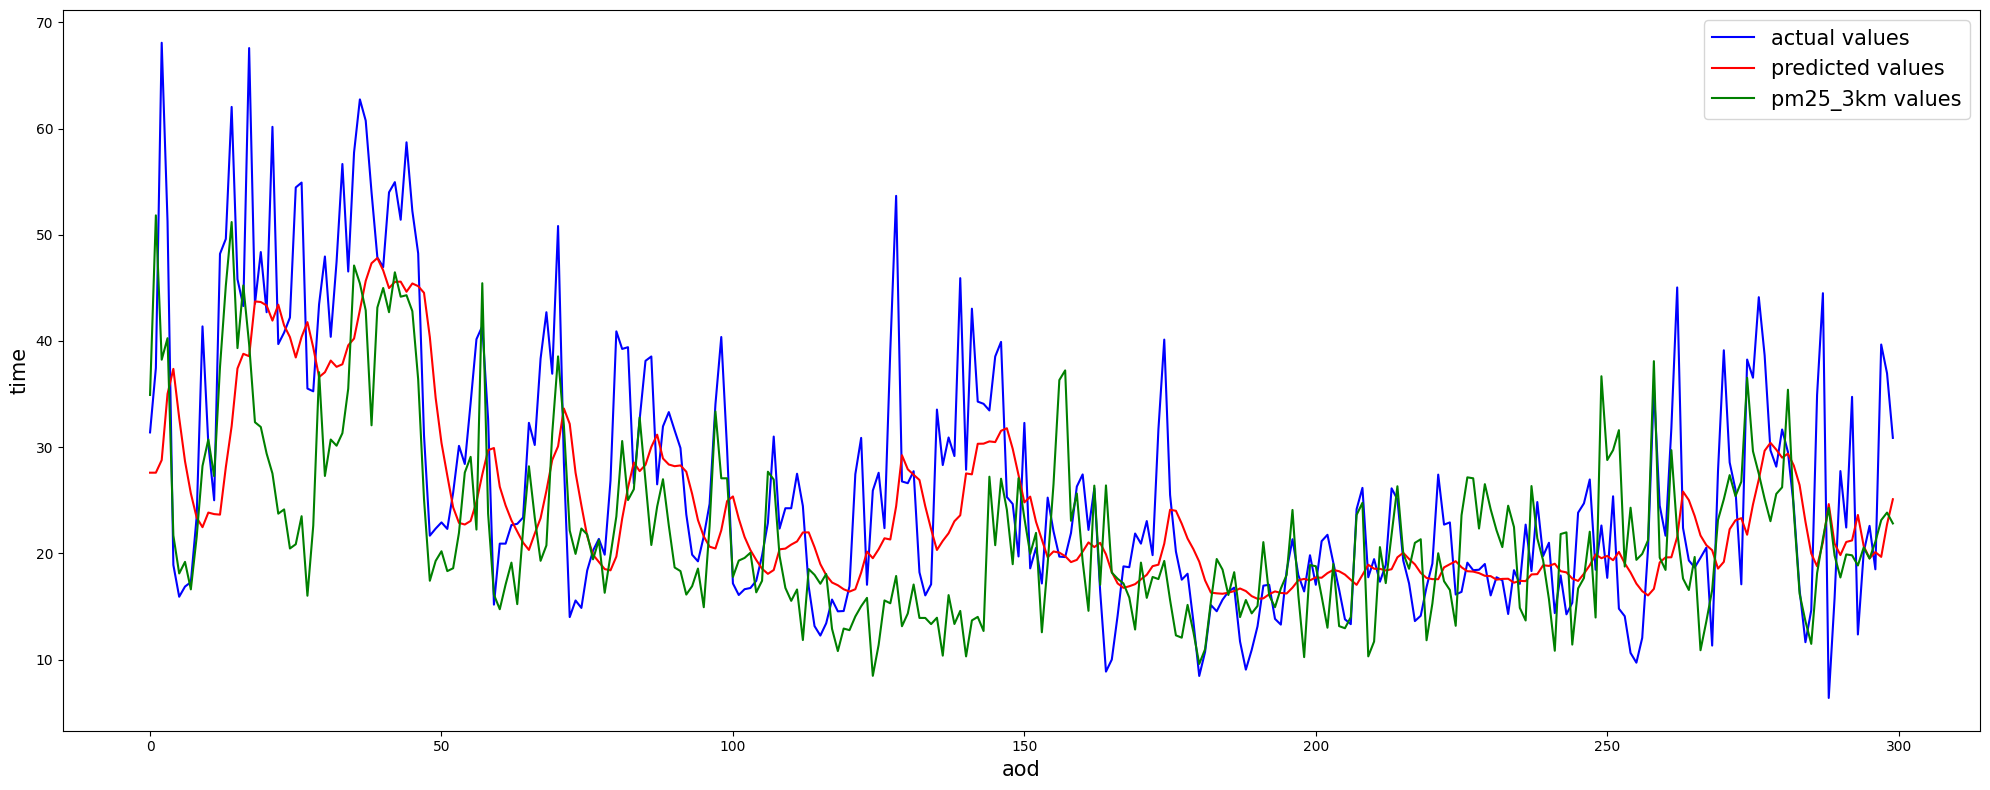

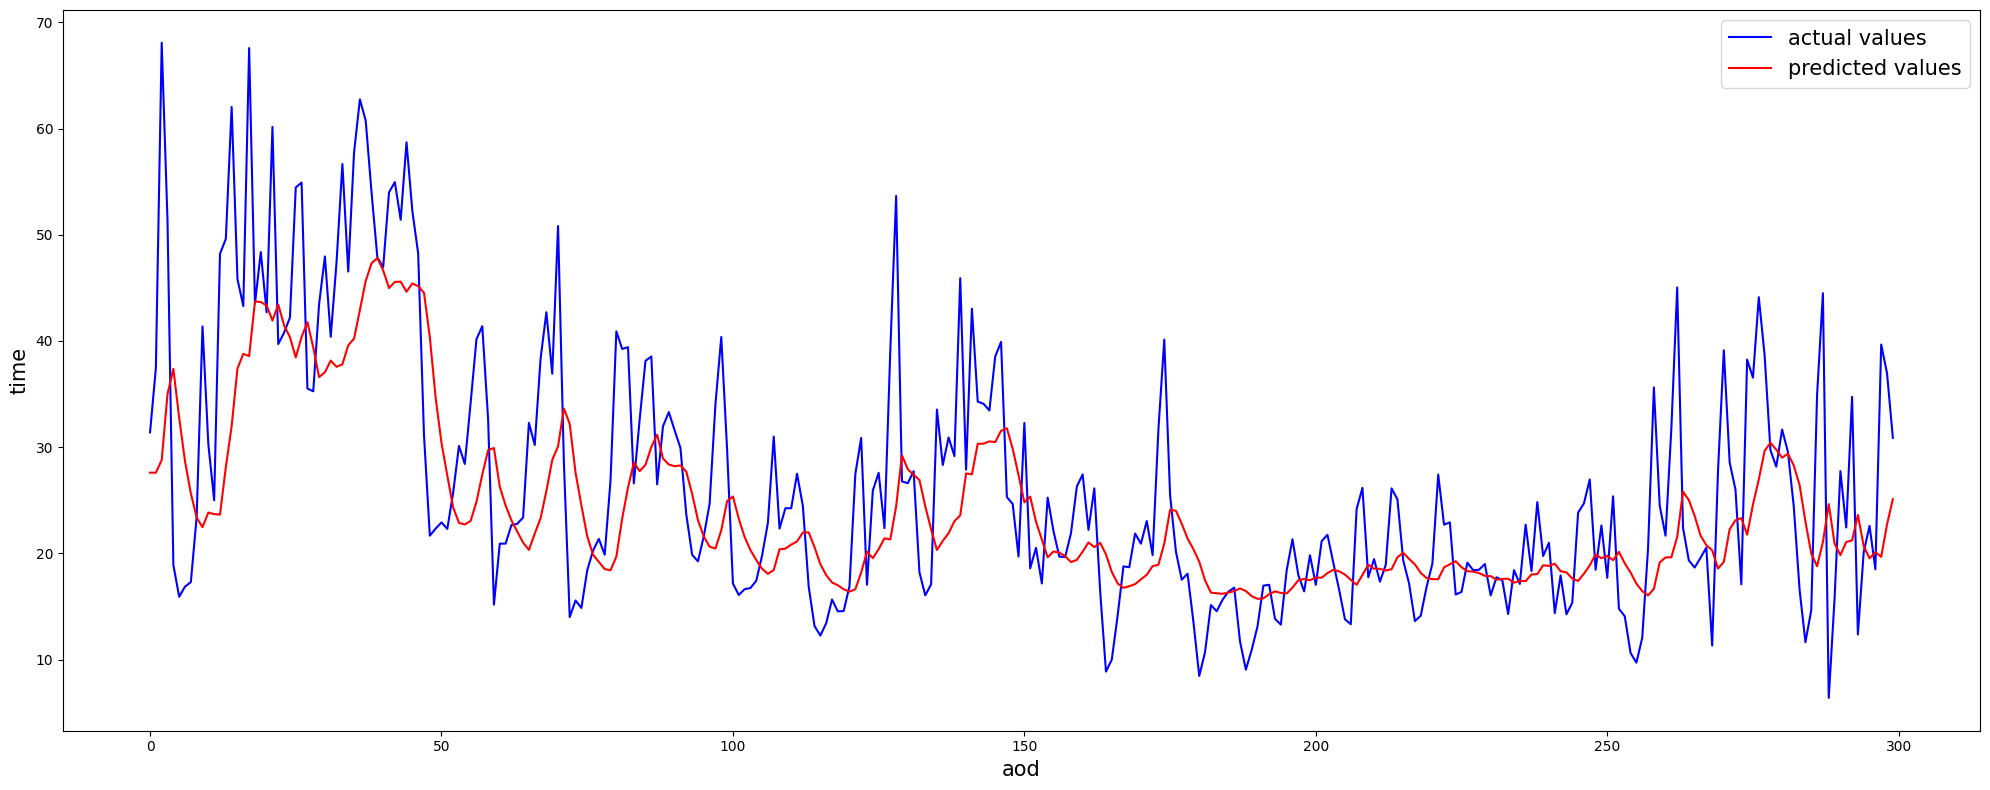

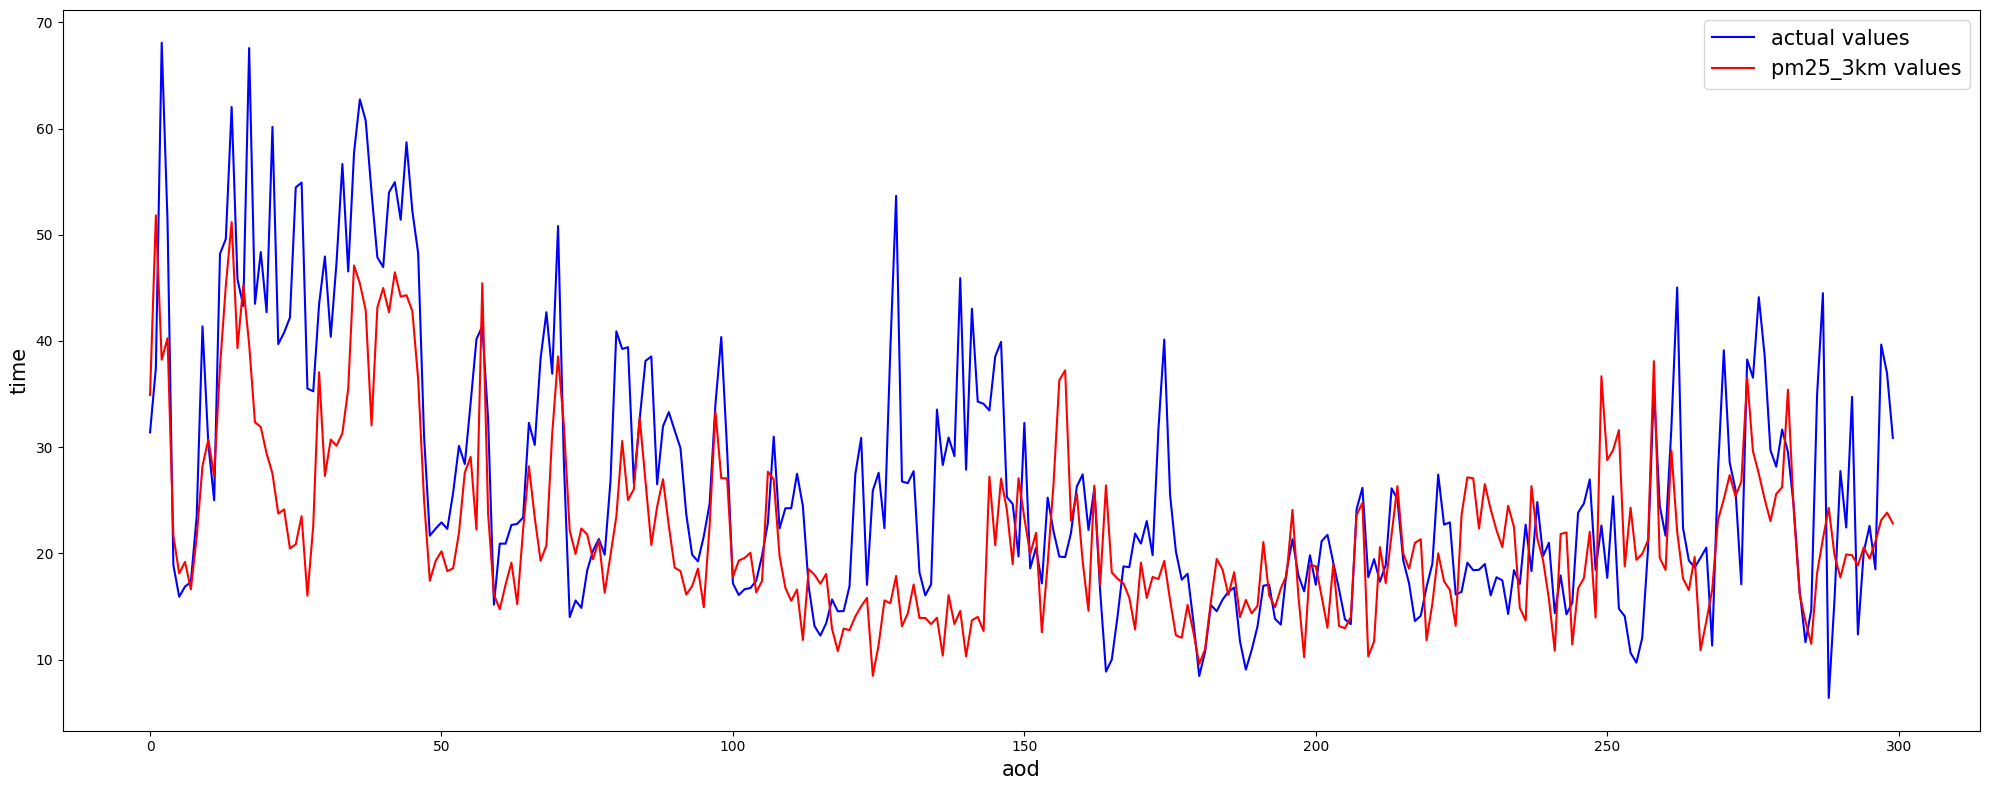

In [89]:
# Compare test set only
all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
y_pred = all_days_inv_y_pred.reshape(-1, 1)
y_test = all_days_inv_y_test.reshape(-1, 1)
test_len = y_test.shape[0]
aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
print("On test data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_test, aod_pm25_3km_column_test)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE between actual and pm25_3km: {mean_squared_error(y_test, aod_pm25_3km_column_test)}")
print(f"MSE between actual and predicted pm25: {mean_squared_error(y_test, y_pred)}")
plot_3_data(data1=y_test,
           datalabel1="actual values",
           data2=y_pred,
           datalabel2="predicted values",
           data3=aod_pm25_3km_column_test,
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")

# Compare entire dataset
print("On entire data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_aod, aod_pm25_3km_column)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_aod, inv_pred_pm25_from_df_lstms2s_reduced)}")
plot_3_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=inv_pred_pm25_from_df_lstms2s_reduced[:300],
           datalabel2="predicted values",
           data3=aod_pm25_3km_column.head(300),
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=inv_pred_pm25_from_df_lstms2s_reduced[:300],
           datalabel2="predicted values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=aod_pm25_3km_column.head(300),
           datalabel2="pm25_3km values",
           ylabel="time",
           xlabel="aod")

#### Compare MAE with CMAQ pm25

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2022-01-01       0.171227      -2.706160       0.020523       0.312584   
2022-01-02       0.169182      -2.688891       0.023076       0.311417   
2022-01-03       0.164779      -2.646638       0.023820       0.307438   
2022-01-04       0.160238      -2.608070       0.024070       0.304612   
2022-01-05       0.158516      -2.567016       0.024922       0.295560   
...                   ...            ...            ...            ...   
2022-12-27       0.272879      -2.043603       0.513575       0.017978   
2022-12-28       0.269774      -2.041911       0.513041       0.019930   
2022-12-29       0.267473      -2.025659       0.513671       0.018630   
2022-12-30       0.266768      -2.019120       0.516159       0.014758   
2022-12-31       0.269087      -2.028699       0.519035       0.012311   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2022-01-01       0.257879      -0.265297       1.029480      -0.936515   
2022-01-02       0.253359      -0.264551       1.022123      -0.930973   
2022-01-03       0.246598      -0.263100       1.003042      -0.917727   
2022-01-04       0.240890      -0.261781       0.984843      -0.906768   
2022-01-05       0.241425      -0.263333       0.962862      -0.892483   
...                   ...            ...            ...            ...   
2022-12-27       0.277397      -0.468598       0.525131      -0.811342   
2022-12-28       0.276108      -0.467782       0.527113      -0.813002   
2022-12-29       0.273738      -0.466812       0.519790      -0.808541   
2022-12-30       0.275181      -0.467994       0.517804      -0.805006   
2022-12-31       0.278635      -0.471093       0.521433      -0.806786   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2022-01-01       0.743071        0.044281       -1.055001        2.784191   
2022-01-02       0.734500        0.046204       -1.048115        2.765878   
2022-01-03       0.722742        0.043191       -1.030235        2.722209   
2022-01-04       0.709972        0.042042       -1.014266        2.682495   
2022-01-05       0.701817        0.036243       -1.003951        2.640404   
...                   ...             ...             ...             ...   
2022-12-27       0.955001       -0.186581       -0.736648        1.899977   
2022-12-28       0.953752       -0.184653       -0.733380        1.899572   
2022-12-29       0.946751       -0.183920       -0.726910        1.882394   
2022-12-30       0.946459       -0.185701       -0.726849        1.873379   
2022-12-31       0.953368       -0.187639       -0.733271        1.880918   

            aod_feature_13  aod_feature_14  station  predicted_pm25   pm25_3km  
time                                                                            
2022-01-01        0.999619        0.349328      201       23.260258  22.705284  
2022-01-02        0.991732        0.346120      201       21.961315  24.095436  
2022-01-03        0.977590        0.340110      201       21.441114  45.302227  
2022-01-04        0.963995        0.333121      201       22.295303  49.729404  
2022-01-05        0.950392        0.326128      201       26.823629  32.204433  
...                    ...             ...      ...             ...        ...  
2022-12-27        0.448741        0.392878      216       24.805321  34.439411  
2022-12-28        0.449230        0.394062      216       26.537874  29.838476  
2022-12-29        0.443144        0.389132      216       28.333265  28.450829  
2022-12-30        0.440165        0.387777      216       28.064348  19.854403  
2022-12-31        0.441839        0.389712      216       28.218998  27.658358  

[998 rows x 17 columns]

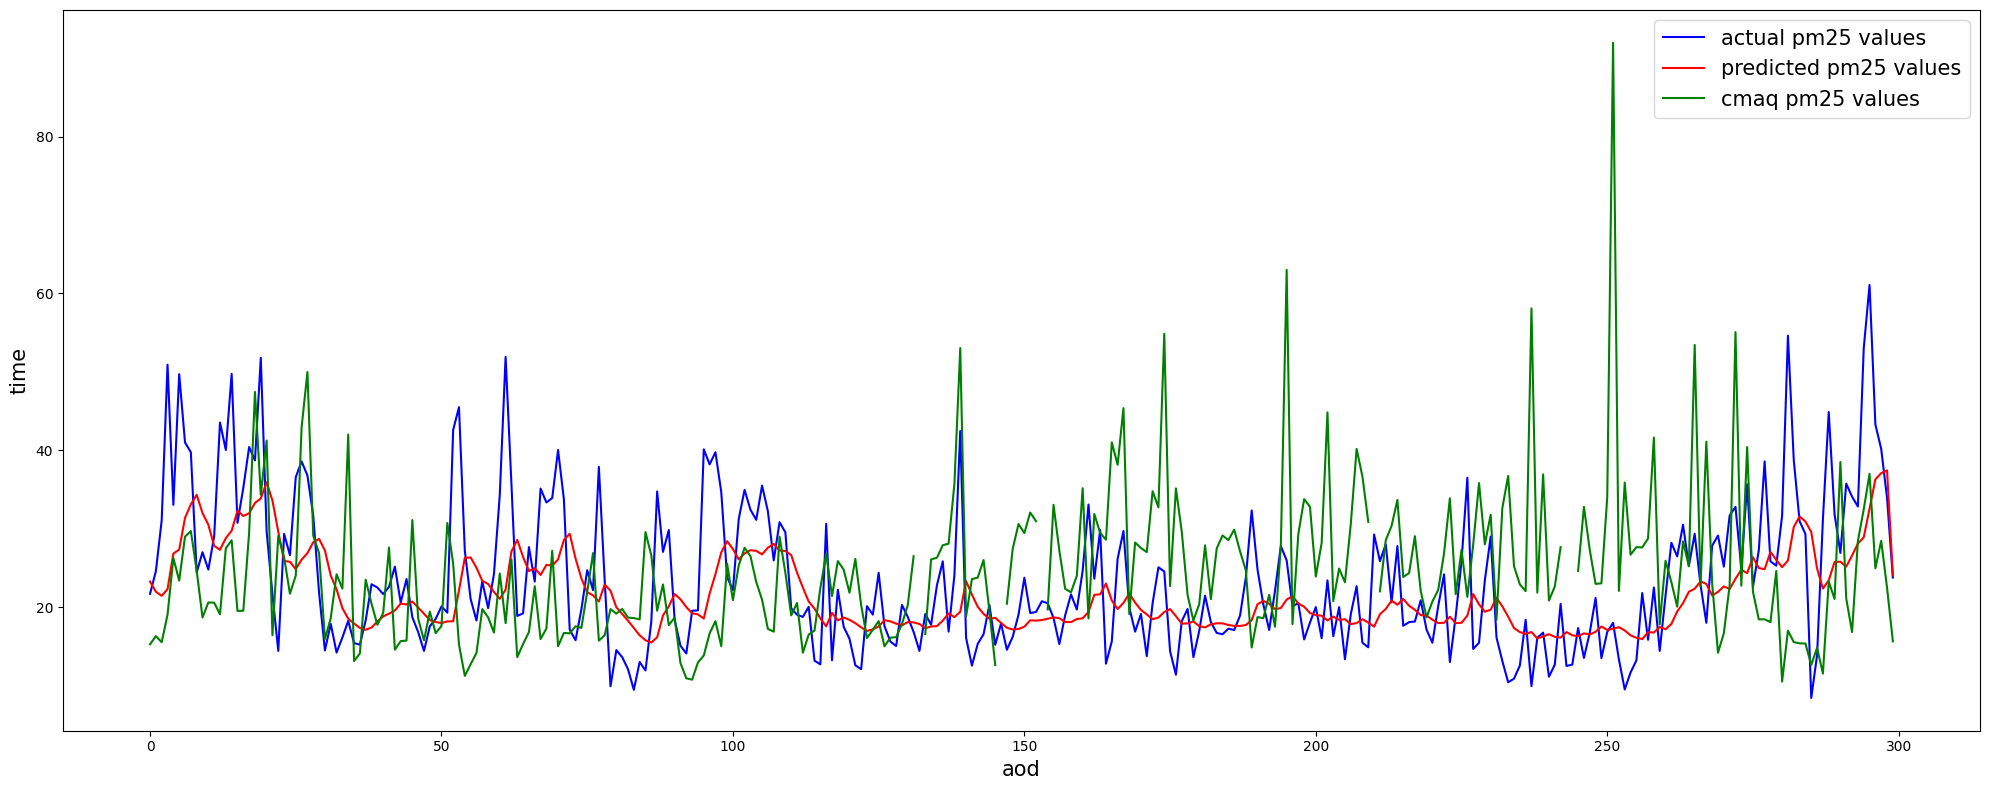

In [90]:
# Remove station 202
df_lstms2s_reduced_dropped_202 = df_lstms2s_reduced[df_lstms2s_reduced["station"] != 202]
df_aod_dropped_202 = df_aod[df_aod["station"] != 202]

time_mask = ((df_aod_dropped_202.index >= "2022-01-01") & (df_aod_dropped_202.index <= "2022-12-31"))
df_aod_dropped_202 = df_aod_dropped_202.loc[time_mask]
#display(df_aod_dropped_202)

time_mask = ((df_lstms2s_reduced_dropped_202.index >= "2022-01-01") & (df_lstms2s_reduced_dropped_202.index <= "2022-12-31"))
df_lstms2s_reduced_dropped_202 = df_lstms2s_reduced_dropped_202.loc[time_mask]
display(df_lstms2s_reduced_dropped_202)

# Compare entire dataset
plot_3_data(data1=df_aod_dropped_202["pm25"].head(300),
           datalabel1="actual pm25 values",
           data2=df_lstms2s_reduced_dropped_202["predicted_pm25"].head(300),
           datalabel2="predicted pm25 values",
           data3=df_cmaq_daily["pm25"].head(300),
           datalabel3="cmaq pm25 values",
           ylabel="time",
           xlabel="aod")

### Prediction + GRU-Seq2Seq

#### Doing the loop

GRUSeq2SeqReduction._prepare_data(): is called
GRUSeq2SeqReduction._define_model(): is called
GRUSeq2SeqReduction.execute(): is called
GRUSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - loss: 0.1911 - val_loss: 0.0843
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0746 - val_loss: 0.0865
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0657 - val_loss: 0.0830
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0627 - val_loss: 0.0819
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0591 - val_loss: 0.0822
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0520 - val_loss: 0.0786
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0463 - val_loss: 0.0790
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0461 - val_loss: 0.0717
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0414 - val_loss: 0.0673
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0429 - val_loss: 0.0646
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0300 - val_loss: 0.0605
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/st

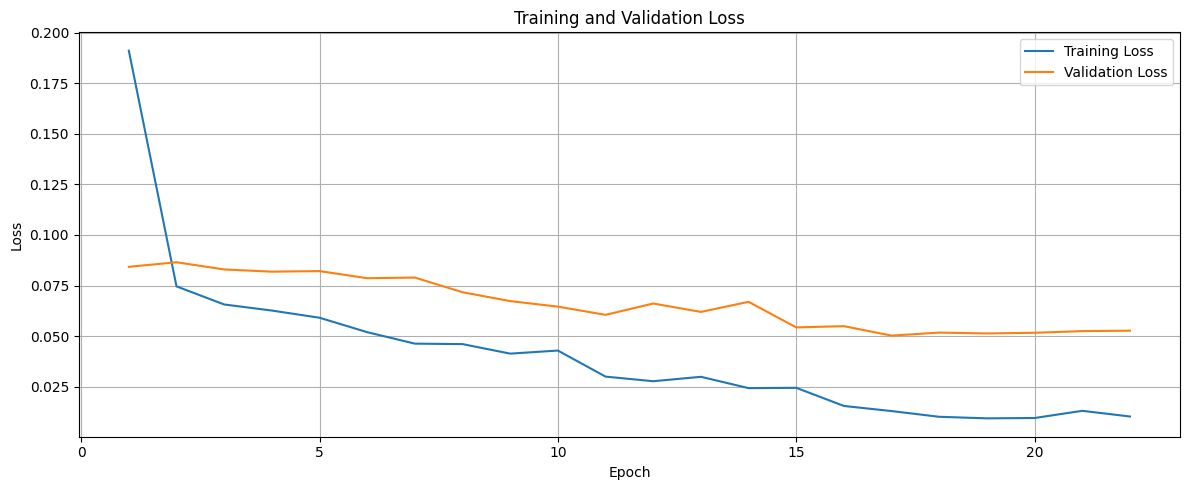

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0405
GRUSeq2SeqReduction.execute(): mae = 0.04053553566336632
GRUSeq2SeqReduction._define_encoder_model(): is called
GRUSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


Model: "aod_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 7, 100)    │     36,000 │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ [(None, 50),      │     22,800 │ gru_8[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 14)        │        714 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_26    │ (None, 7, 14)     │          0 │ dense_36[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 7, 50)     │      9,900 │ repeat_vector_26… │
│                     │                   │            │ gru_9[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_26 │ (None, 7, 18)     │      1,818 │ gru_11[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 350,498 (1.34 MB)

 Trainable params: 116,832 (456.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,666 (912.76 KB)

None


Model: "aod_GRUSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,514 (232.48 KB)

 Trainable params: 59,514 (232.48 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_48 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_34[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_27    │ (None, 1, 64)     │          0 │ lstm_48[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_49 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_27… │
│                     │                   │            │ lstm_48[0][1],    │
│                     │                   │            │ lstm_48[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 1, 64)     │          0 │ lstm_49[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, 1, 1)      │         65 │ dropout_12[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 0.0492 - val_loss: 0.0134
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - val_loss: 0.0105
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0136 - val_loss: 0.0100
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0130 - val_loss: 0.0095
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124 - val_loss: 0.0090
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - val_loss: 0.0083
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103 - val_loss: 0.0078
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0099 - val_loss: 0.0077
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0098 - val_loss: 0.0076
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

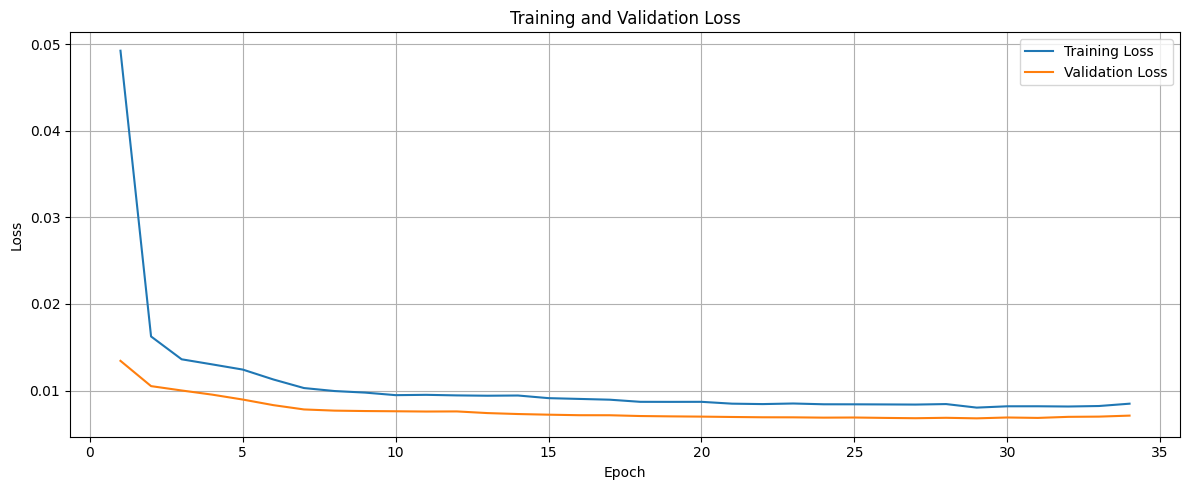

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Day 1 - mae = 4.287930990218901, mse = 30.351680794176758, r2 = -0.7296670455889138, rmse = 5.509235953757722, mape = 0.23276910422040276, mnbe = 4.369792032803075
avg_mae = 4.287930990218901
avg_mse = 30.351680794176758
avg_r2 = -0.7296670455889138
avg_rmse = 5.509235953757722
avg_mape = 0.23276910422040276
avg_mnbe = 4.369792032803075
GRUSeq2SeqReduction._prepare_data(): is called
GRUSeq2SeqReduction._define_model(): is called
GRUSeq2SeqReduction.execute(): is called
GRUSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 308ms/step - loss: 0.1810 - val_loss: 0.1122
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0740 - val_loss: 0.0824
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0626 - val_loss: 0.0838
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0595 - val_loss: 0.0811
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0550 - val_loss: 0.0746
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0467 - val_loss: 0.0635
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0389 - val_loss: 0.0620
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0358 - val_loss: 0.0620
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0393 - val_loss: 0.0640
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0399 - val_loss: 0.0613
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0488 - val_loss: 0.0598
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/st

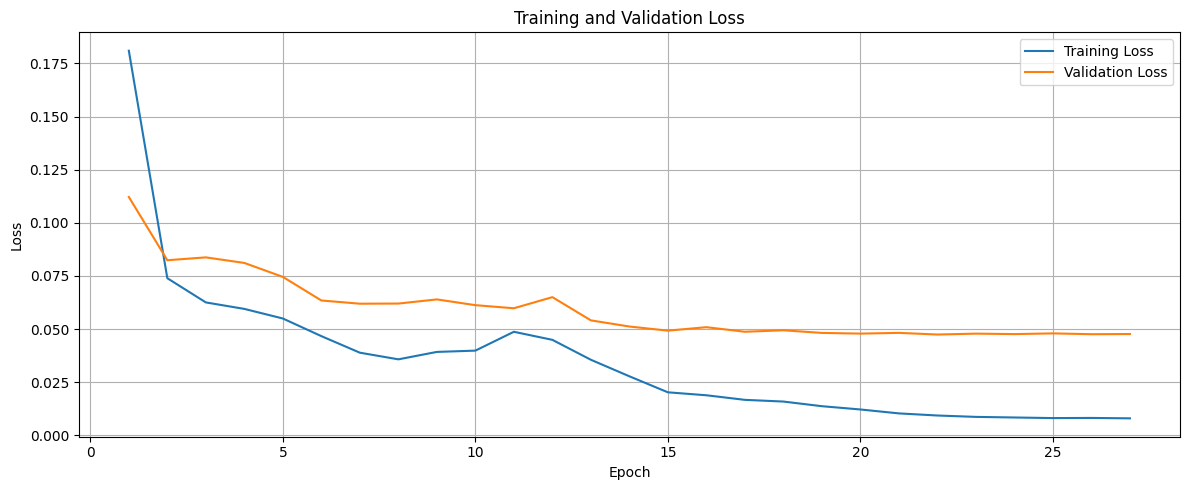

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0361
GRUSeq2SeqReduction.execute(): mae = 0.03612241521477699
GRUSeq2SeqReduction._define_encoder_model(): is called
GRUSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


Model: "aod_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_35[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ [(None, 50),      │     22,800 │ gru_12[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 15)        │        765 │ gru_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_28    │ (None, 7, 15)     │          0 │ dense_39[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 7, 50)     │     10,050 │ repeat_vector_28… │
│                     │                   │            │ gru_13[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, 7, 18)     │      1,818 │ gru_15[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,101 (1.34 MB)

 Trainable params: 117,033 (457.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,068 (914.33 KB)

None


Model: "aod_GRUSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,565 (232.68 KB)

 Trainable params: 59,565 (232.68 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_50 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_37[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_29    │ (None, 1, 64)     │          0 │ lstm_50[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_51 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_29… │
│                     │                   │            │ lstm_50[0][1],    │
│                     │                   │            │ lstm_50[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 1, 64)     │          0 │ lstm_51[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, 1, 1)      │         65 │ dropout_13[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 0.0359 - val_loss: 0.0130
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0145 - val_loss: 0.0107
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0129 - val_loss: 0.0101
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117 - val_loss: 0.0092
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - val_loss: 0.0085
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101 - val_loss: 0.0081
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100 - val_loss: 0.0078
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098 - val_loss: 0.0077
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098 - val_loss: 0.0077
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - val_loss: 0.0075
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0

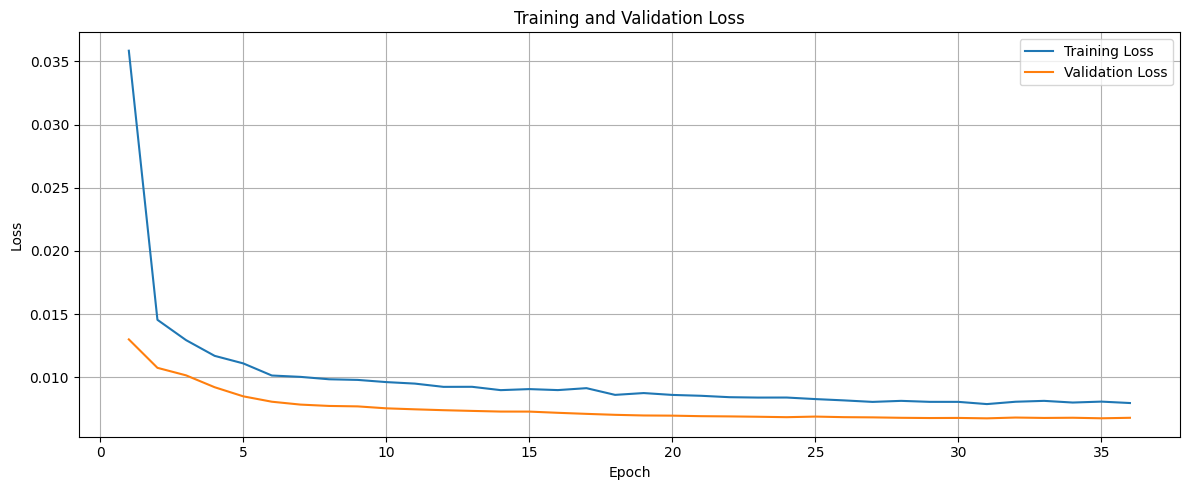

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step 
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Day 1 - mae = 4.303055498476363, mse = 30.548727398283106, r2 = -0.5813683358034907, rmse = 5.52709031935277, mape = 0.23120961424490805, mnbe = 5.531254902007296
avg_mae = 4.303055498476363
avg_mse = 30.548727398283106
avg_r2 = -0.5813683358034907
avg_rmse = 5.52709031935277
avg_mape = 0.23120961424490805
avg_mnbe = 5.531254902007296
Choosing the best result

dict_keys([14, 15])
N = 14
mae = 4.287930990218901
mse = 30.351680794176758
rmse = 5.509235953757722
r2 = -0.7296670455889138
mape = 0.23276910422040276
mnbe = 4.369792032803075
N = 15
mae = 4.303055498476363
mse = 30.548727398283106
rmse = 5.52709031935277
r2 = -0.5813683358034907
mape = 0.23120961424490805
mnbe = 5.531254902007296


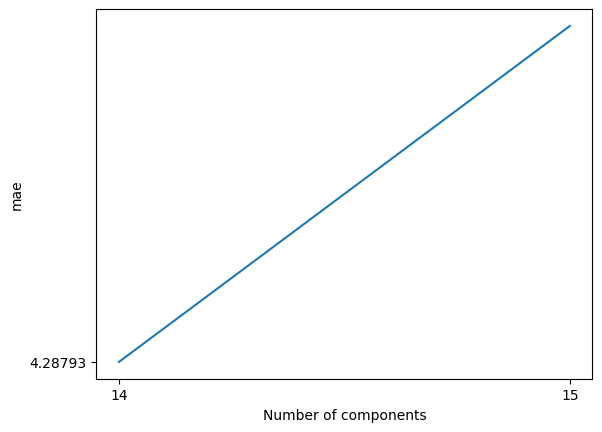

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


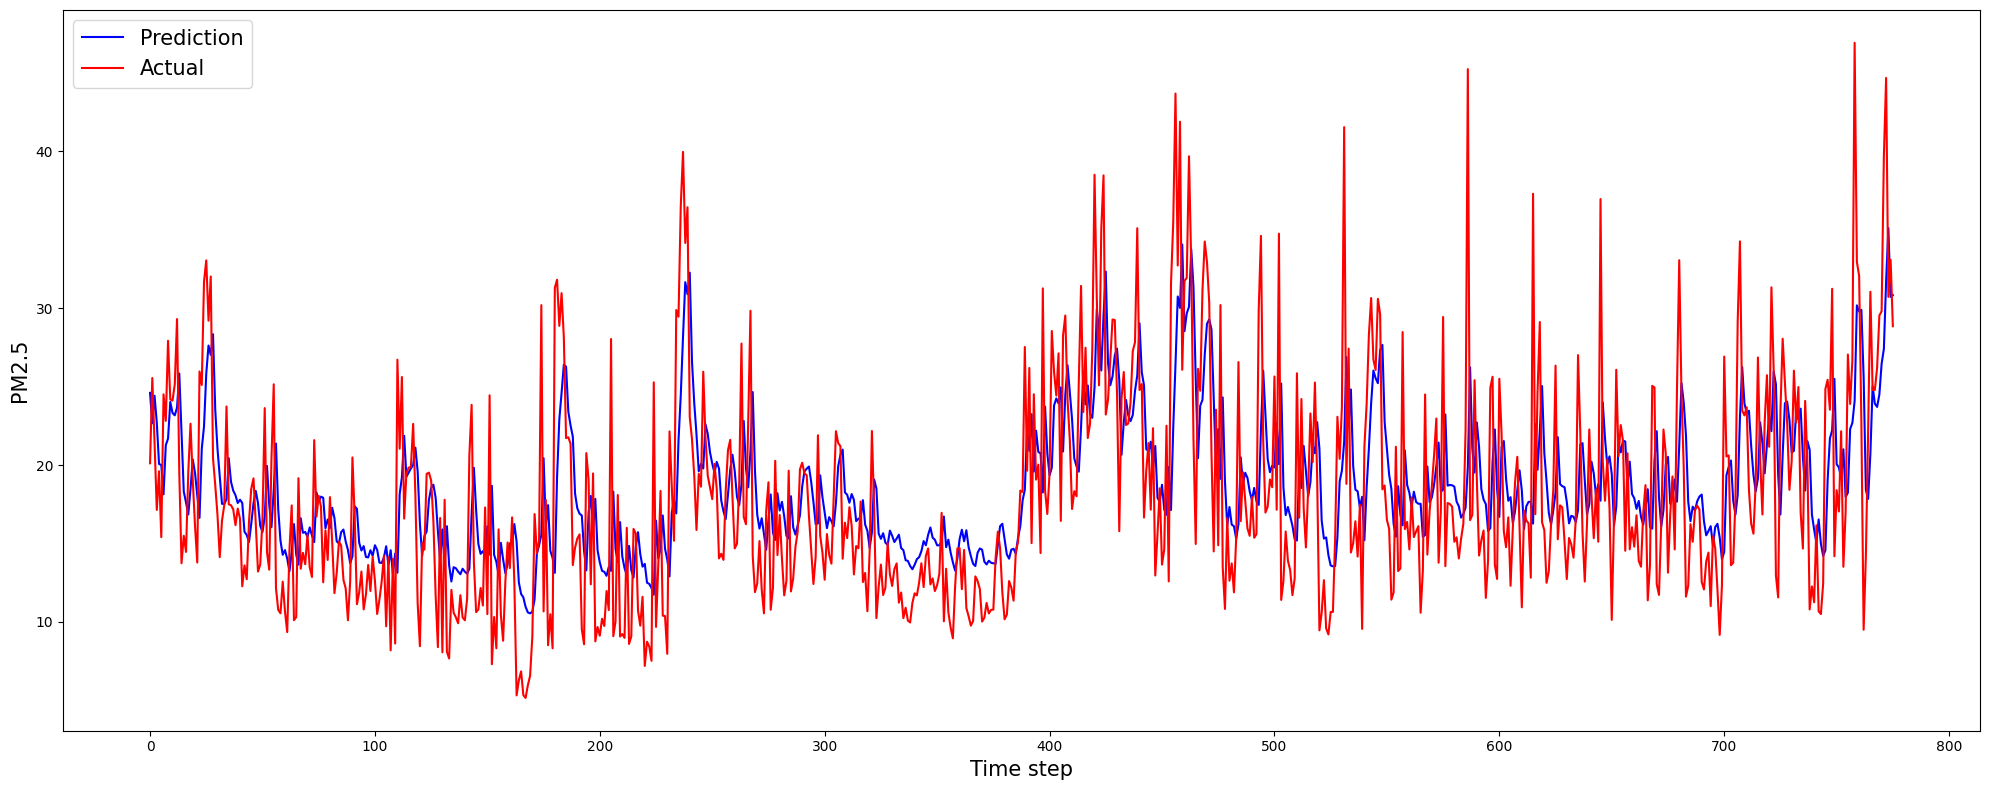

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  7.554098  73.259674   
1         LSTM-Seq2Seq                  14       LSTM  4.886712  35.676570   
2          GRU-Seq2Seq                  14       LSTM  4.287931  30.351681   

       rmse         r2      mape       mnbe  
0  8.559187 -13.770773  0.322306  31.938908  
1  5.972987  -3.234626  0.256904   7.334278  
2  5.509236  -0.729667  0.232769   4.369792

In [91]:
loopresults = generate_loopresults(X_aod_scaled, y_aod_scaled,
                                   aod_label_scaler,
                                   range_of_dimension,
                                   GRUSeq2SeqReduction,
                                   LSTMPrediction,
                                   reduction_n_past, reduction_n_future,
                                   reduction_epochs, reduction_batch_size,
                                   prediction_n_past, prediction_n_future,
                                   prediction_epochs, prediction_batch_size)
best = choose_the_best(loopresults, metric_to_choose="mae")
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path = best

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [92]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Inference LSTM
pred_pm25_from_df_grus2s_reduced = inferenceLSTM(best_encoded_data, y_aod_scaled,
                                                    prediction_n_past, prediction_n_future,
                                                    best_prediction_model_path, verbose=1)
inv_pred_pm25_from_df_grus2s_reduced = aod_label_scaler.inverse_transform(pred_pm25_from_df_grus2s_reduced.reshape(-1, 1))
print(inv_pred_pm25_from_df_grus2s_reduced.shape)
print(inv_pred_pm25_from_df_grus2s_reduced)

# Prepare the reduced data
df_grus2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices,
                                        (aod_station_column, "station"),
                                        (inv_pred_pm25_from_df_grus2s_reduced, "predicted_pm25"),
                                        (aod_pm25_3km_column, "pm25_3km"))
df_grus2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data_dir"], "df_grus2s_reduced_2018_2022.csv"))
df_grus2s_reduced.to_csv(os.path.join(conf["workspace"]["data_to_store_in_hdfs_dir"], "vientham_2018_2022_reduced_with_grus2s.csv"))
df_grus2s_reduced

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
(3889, 1)
[[28.663433]
 [28.663433]
 [31.479595]
 ...
 [35.108093]
 [30.71974 ]
 [30.83638 ]]


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.045535       0.054014       0.159954       0.026958   
2018-01-02       0.045535       0.054014       0.159954       0.026958   
2018-01-03       0.045504       0.053987       0.159893       0.026977   
2018-01-04       0.045298       0.053724       0.160173       0.026873   
2018-01-05       0.045037       0.053452       0.160898       0.026524   
...                   ...            ...            ...            ...   
2022-12-27       0.055356       0.051153       0.063400       0.046863   
2022-12-28       0.055194       0.051196       0.063357       0.046866   
2022-12-29       0.055089       0.051251       0.063540       0.046847   
2022-12-30       0.054933       0.051172       0.063789       0.046986   
2022-12-31       0.055261       0.050825       0.063748       0.047177   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.100937       0.053214       0.068675       0.016788   
2018-01-02       0.100937       0.053214       0.068675       0.016788   
2018-01-03       0.100900       0.053271       0.068647       0.016868   
2018-01-04       0.100739       0.053016       0.068394       0.016805   
2018-01-05       0.100636       0.052326       0.068222       0.016465   
...                   ...            ...            ...            ...   
2022-12-27       0.099341       0.088898       0.080687       0.045770   
2022-12-28       0.099973       0.088619       0.080932       0.045837   
2022-12-29       0.099907       0.088768       0.080633       0.045706   
2022-12-30       0.099743       0.088975       0.080337       0.045384   
2022-12-31       0.099001       0.088856       0.080219       0.045405   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       0.014018        0.024446        0.051801        0.084497   
2018-01-02       0.014018        0.024446        0.051801        0.084497   
2018-01-03       0.014050        0.024503        0.051895        0.084541   
2018-01-04       0.013948        0.024365        0.052034        0.084655   
2018-01-05       0.013667        0.024053        0.051881        0.084412   
...                   ...             ...             ...             ...   
2022-12-27       0.032220        0.028018        0.111830        0.027667   
2022-12-28       0.032198        0.028058        0.111600        0.027706   
2022-12-29       0.032107        0.028026        0.111669        0.027801   
2022-12-30       0.031867        0.027803        0.111734        0.027963   
2022-12-31       0.031784        0.027548        0.111855        0.027907   

            aod_feature_13  aod_feature_14  station  predicted_pm25   pm25_3km  
time                                                                            
2018-01-01        0.270028        0.029136      201       28.663433  34.919998  
2018-01-02        0.270028        0.029136      201       28.663433  51.830002  
2018-01-03        0.269780        0.029183      201       31.479595  38.240002  
2018-01-04        0.270946        0.029031      201       41.098297  40.259998  
2018-01-05        0.273781        0.028644      201       41.968754  21.690001  
...                    ...             ...      ...             ...        ...  
2022-12-27        0.171358        0.097440      216       27.403927  34.439411  
2022-12-28        0.170851        0.097614      216       31.708401  29.838476  
2022-12-29        0.170890        0.097766      216       35.108093  28.450829  
2022-12-30        0.171350        0.097965      216       30.719740  19.854403  
2022-12-31        0.172343        0.098071      216       30.836380  27.658358  

[3889 rows x 17 columns]

#### Compare MAE with pm25_3km

On test data:
MAE between actual and pm25_3km: 6.785086281801943
MAE between actual and predicted pm25: 4.287930990218901
MSE between actual and pm25_3km: 87.2793385941348
MSE between actual and predicted pm25: 30.351680794176758


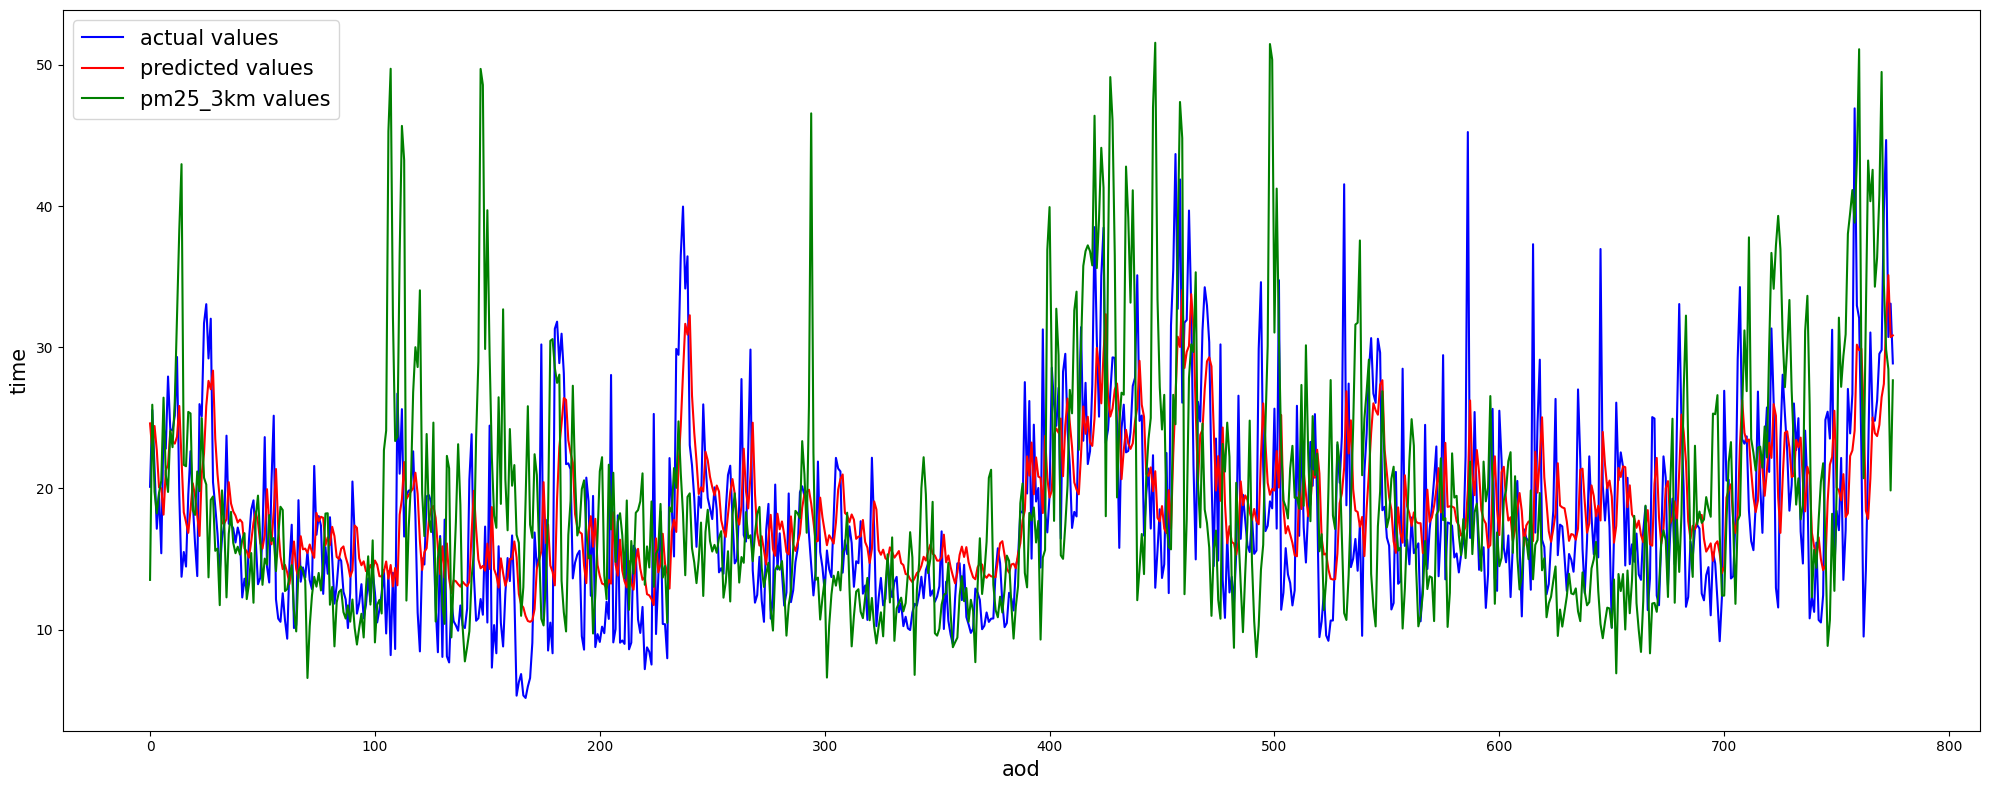

On entire data:
MAE between actual and pm25_3km: 7.875957292759844
MAE between actual and predicted pm25: 5.2282209396362305


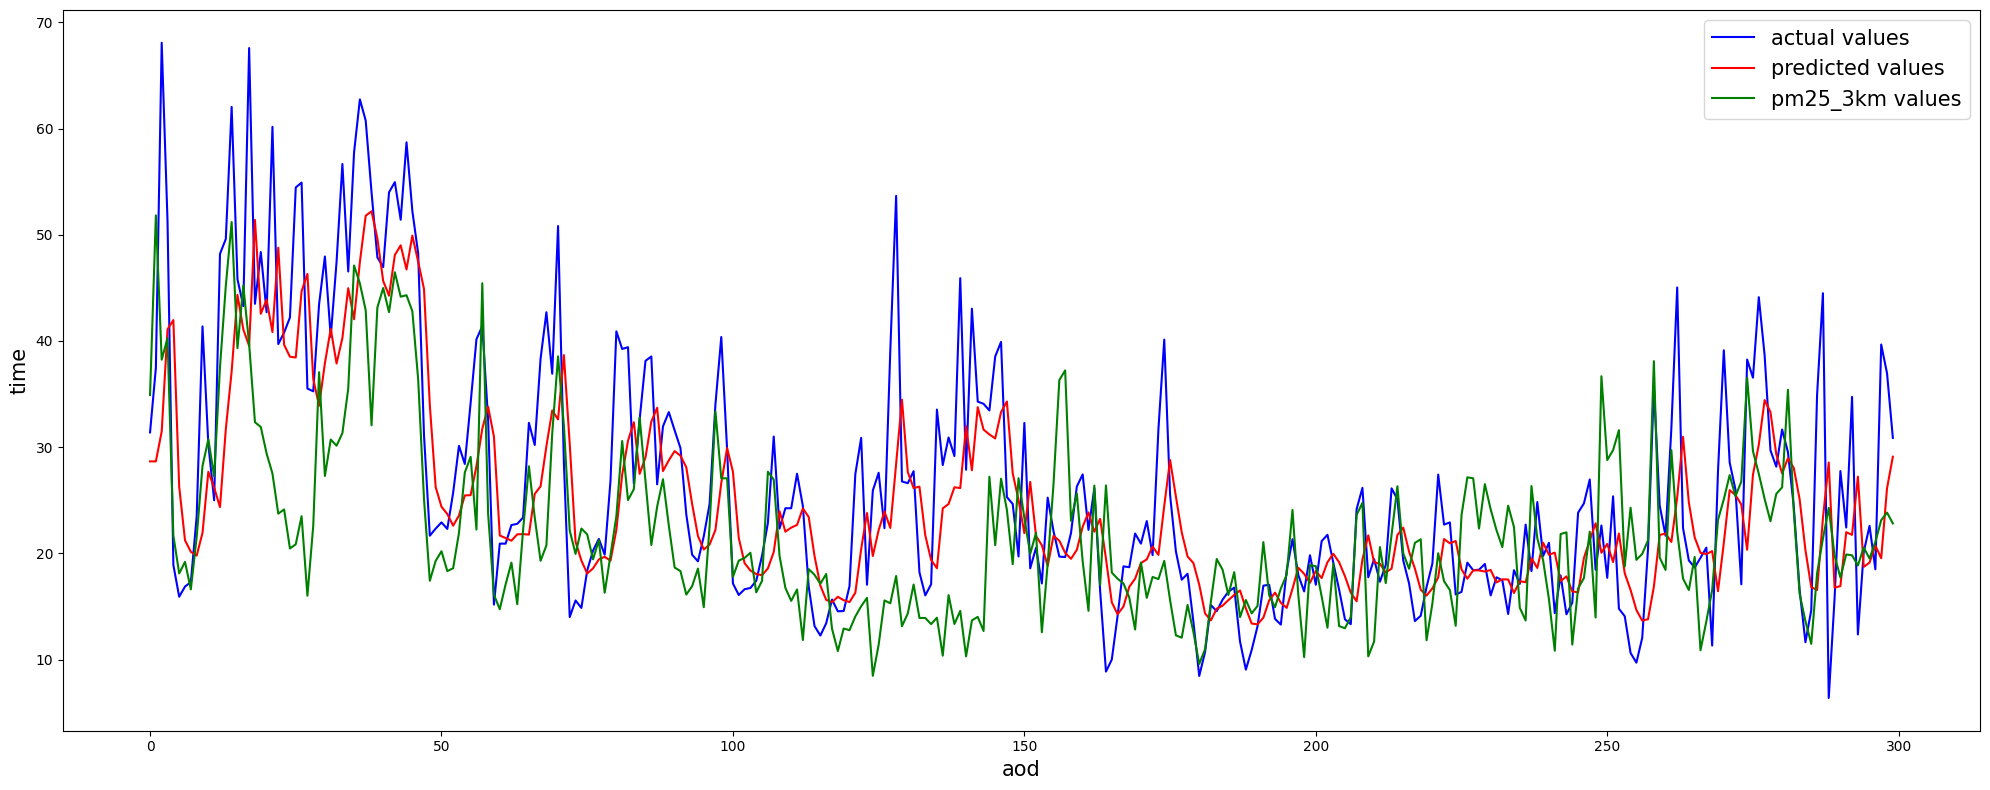

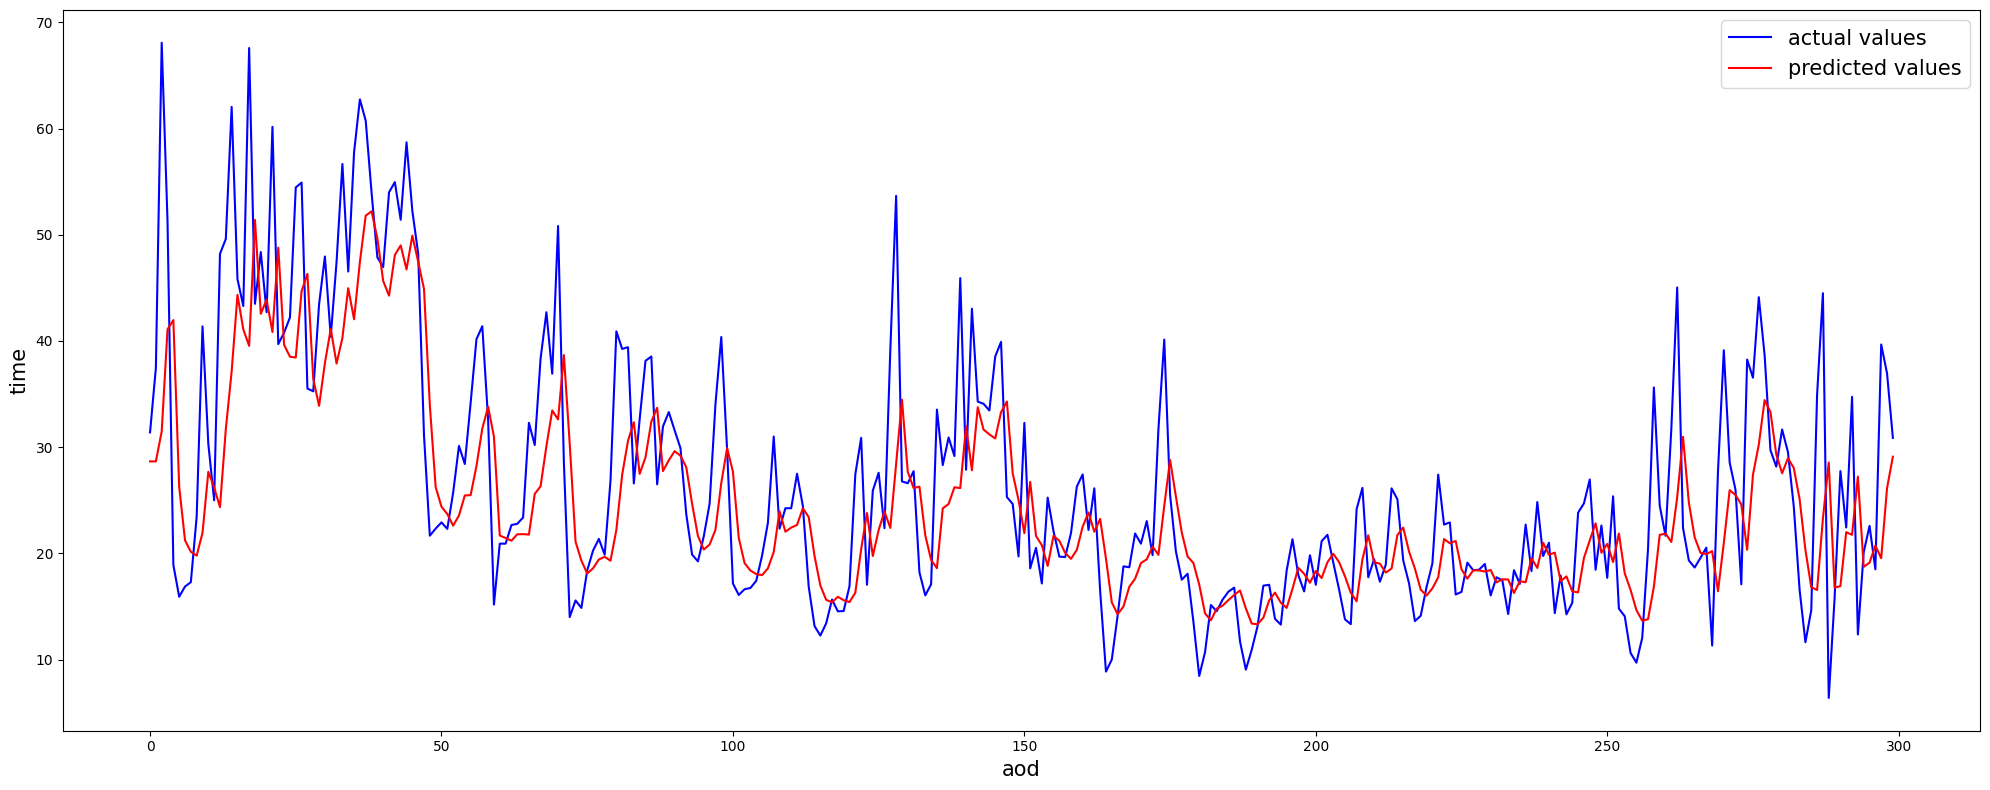

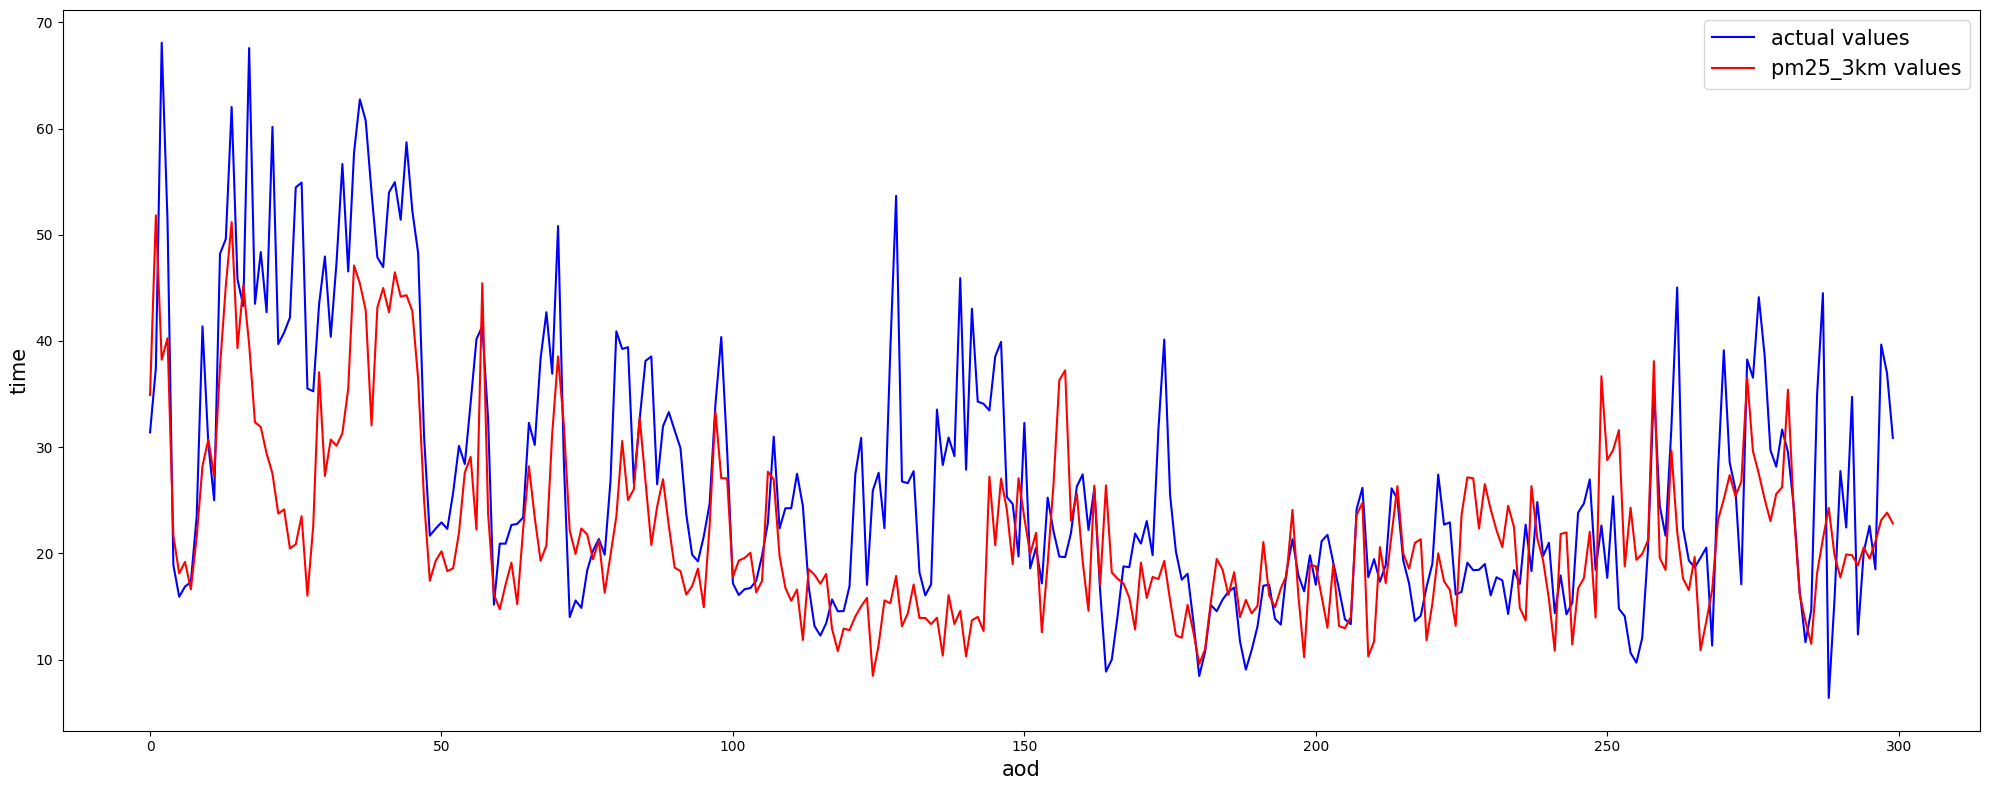

In [93]:
# Compare test set only
all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
y_pred = all_days_inv_y_pred.reshape(-1, 1)
y_test = all_days_inv_y_test.reshape(-1, 1)
test_len = y_test.shape[0]
aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
print("On test data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_test, aod_pm25_3km_column_test)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE between actual and pm25_3km: {mean_squared_error(y_test, aod_pm25_3km_column_test)}")
print(f"MSE between actual and predicted pm25: {mean_squared_error(y_test, y_pred)}")
plot_3_data(data1=y_test,
           datalabel1="actual values",
           data2=y_pred,
           datalabel2="predicted values",
           data3=aod_pm25_3km_column_test,
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")

# Compare entire dataset
print("On entire data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_aod, aod_pm25_3km_column)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_aod, inv_pred_pm25_from_df_grus2s_reduced)}")
plot_3_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=inv_pred_pm25_from_df_grus2s_reduced[:300],
           datalabel2="predicted values",
           data3=aod_pm25_3km_column.head(300),
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=inv_pred_pm25_from_df_grus2s_reduced[:300],
           datalabel2="predicted values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=aod_pm25_3km_column.head(300),
           datalabel2="pm25_3km values",
           ylabel="time",
           xlabel="aod")

#### Compare MAE with CMAQ pm25

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2022-01-01      201  21.695652  10.783456  106.700622  22.705284  27.787918   
2022-01-02      201  24.583333  10.783456  106.700622  24.095436  24.707085   
2022-01-03      201  31.083333  10.783456  106.700622  45.302227  26.576595   
2022-01-04      201  50.916667  10.783456  106.700622  49.729404  26.506687   
2022-01-05      201  33.041667  10.783456  106.700622  32.204433  26.590250   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2022-01-01  61.073841  659.863586  1.885687  20680.62695  ...   
2022-01-02  65.996597  432.379822  1.432167  20680.62695  ...   
2022-01-03  66.171082  443.947327  1.533191  20680.62695  ...   
2022-01-04  76.320465  432.340332  1.721378  20680.62695  ...   
2022-01-05  79.178970  459.642944  1.762114  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2022-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2022-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2022-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2022-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2022-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2022-01-01  1876.639945  232011.95950    0.0  2700.122924  0.118424  
2022-01-02  1876.639945  232011.95950    0.0  2700.122924  0.484536  
2022-01-03  1876.639945  232011.95950    0.0  2700.122924  0.555172  
2022-01-04  1876.639945  232011.95950    0.0  2700.122924  0.726901  
2022-01-05  1876.639945  232011.95950    0.0  2700.122924  0.743757  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505  

[998 rows x 21 columns]

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2022-01-01       0.045097       0.053187       0.161984       0.026301   
2022-01-02       0.045384       0.053411       0.161209       0.026555   
2022-01-03       0.045724       0.053909       0.160052       0.026919   
2022-01-04       0.045902       0.054066       0.159221       0.027200   
2022-01-05       0.045717       0.053970       0.159432       0.027172   
...                   ...            ...            ...            ...   
2022-12-27       0.055356       0.051153       0.063400       0.046863   
2022-12-28       0.055194       0.051196       0.063357       0.046866   
2022-12-29       0.055089       0.051251       0.063540       0.046847   
2022-12-30       0.054933       0.051172       0.063789       0.046986   
2022-12-31       0.055261       0.050825       0.063748       0.047177   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2022-01-01       0.102037       0.052479       0.068128       0.016040   
2022-01-02       0.102145       0.052909       0.068168       0.016280   
2022-01-03       0.102114       0.053590       0.068366       0.016721   
2022-01-04       0.102051       0.053937       0.068360       0.016997   
2022-01-05       0.101563       0.053596       0.068321       0.016966   
...                   ...            ...            ...            ...   
2022-12-27       0.099341       0.088898       0.080687       0.045770   
2022-12-28       0.099973       0.088619       0.080932       0.045837   
2022-12-29       0.099907       0.088768       0.080633       0.045706   
2022-12-30       0.099743       0.088975       0.080337       0.045384   
2022-12-31       0.099001       0.088856       0.080219       0.045405   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2022-01-01       0.013472        0.023807        0.051234        0.084141   
2022-01-02       0.013723        0.024028        0.051467        0.084115   
2022-01-03       0.014084        0.024433        0.051799        0.084155   
2022-01-04       0.014318        0.024625        0.052209        0.084208   
2022-01-05       0.014247        0.024521        0.052352        0.084367   
...                   ...             ...             ...             ...   
2022-12-27       0.032220        0.028018        0.111830        0.027667   
2022-12-28       0.032198        0.028058        0.111600        0.027706   
2022-12-29       0.032107        0.028026        0.111669        0.027801   
2022-12-30       0.031867        0.027803        0.111734        0.027963   
2022-12-31       0.031784        0.027548        0.111855        0.027907   

            aod_feature_13  aod_feature_14  station  predicted_pm25   pm25_3km  
time                                                                            
2022-01-01        0.273806        0.028287      201       20.450432  22.705284  
2022-01-02        0.272005        0.028602      201       20.996513  24.095436  
2022-01-03        0.268995        0.029139      201       22.439503  45.302227  
2022-01-04        0.267397        0.029510      201       25.626154  49.729404  
2022-01-05        0.268322        0.029455      201       31.740807  32.204433  
...                    ...             ...      ...             ...        ...  
2022-12-27        0.171358        0.097440      216       27.403927  34.439411  
2022-12-28        0.170851        0.097614      216       31.708401  29.838476  
2022-12-29        0.170890        0.097766      216       35.108093  28.450829  
2022-12-30        0.171350        0.097965      216       30.719740  19.854403  
2022-12-31        0.172343        0.098071      216       30.836380  27.658358  

[998 rows x 17 columns]

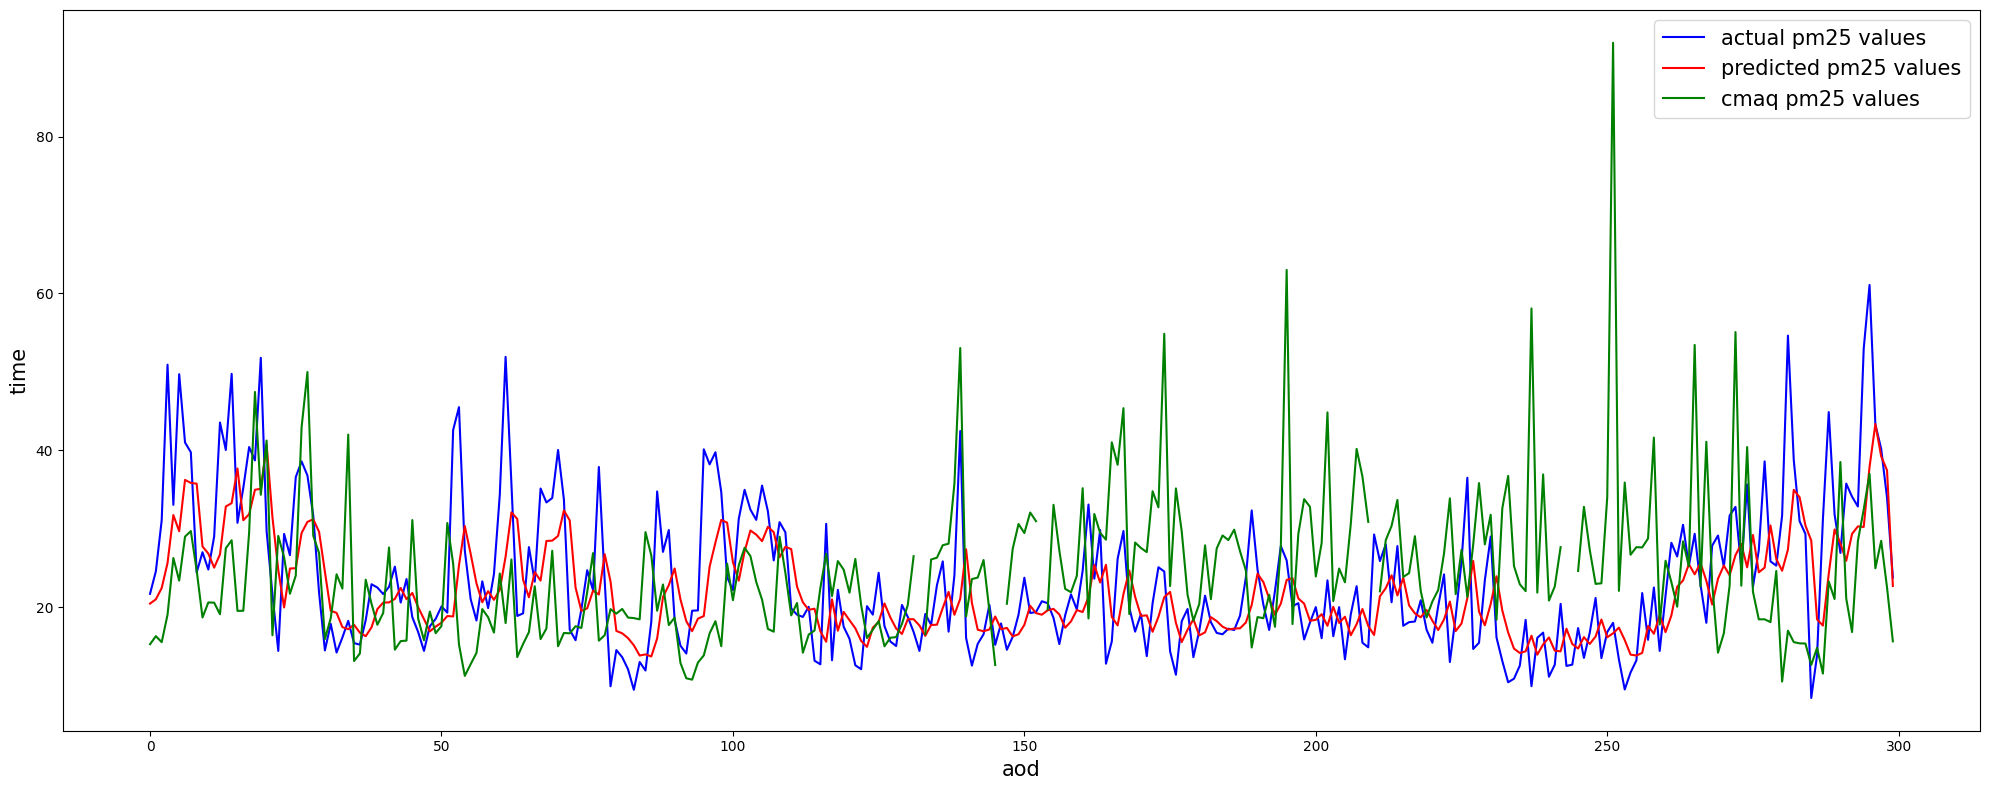

In [94]:
# Remove station 202
df_grus2s_reduced_dropped_202 = df_grus2s_reduced[df_grus2s_reduced["station"] != 202]
df_aod_dropped_202 = df_aod[df_aod["station"] != 202]

time_mask = ((df_aod_dropped_202.index >= "2022-01-01") & (df_aod_dropped_202.index <= "2022-12-31"))
df_aod_dropped_202 = df_aod_dropped_202.loc[time_mask]
display(df_aod_dropped_202)

time_mask = ((df_grus2s_reduced_dropped_202.index >= "2022-01-01") & (df_grus2s_reduced_dropped_202.index <= "2022-12-31"))
df_grus2s_reduced_dropped_202 = df_grus2s_reduced_dropped_202.loc[time_mask]
display(df_grus2s_reduced_dropped_202)

# Compare entire dataset
plot_3_data(data1=df_aod_dropped_202["pm25"].head(300),
           datalabel1="actual pm25 values",
           data2=df_grus2s_reduced_dropped_202["predicted_pm25"].head(300),
           datalabel2="predicted pm25 values",
           data3=df_cmaq_daily["pm25"].head(300),
           datalabel3="cmaq pm25 values",
           ylabel="time",
           xlabel="aod")

### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

In [ ]:
loopresults = generate_loopresults(X_aod_scaled, y_aod_scaled,
                                   aod_label_scaler,
                                   range_of_dimension,
                                   CNNLSTMSeq2SeqReduction,
                                   LSTMPrediction,
                                   reduction_n_past, reduction_n_future,
                                   reduction_epochs, reduction_batch_size,
                                   prediction_n_past, prediction_n_future,
                                   prediction_epochs, prediction_batch_size,
                                   saved_model_weight_dir, saved_model_plot_dir)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

CNNLSTMSeq2SeqReduction._prepare_data(): is called
CNNLSTMSeq2SeqReduction._define_model(): is called
CNNLSTMSeq2SeqReduction.execute(): is called
CNNLSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200


#### Prepare reduced data

In [ ]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Inference LSTM
pred_pm25_from_df_cnnlstms2s_reduced = inferenceLSTM(best_encoded_data, y_aod_scaled,
                                                    prediction_n_past, prediction_n_future,
                                                    best_prediction_model_path, verbose=1)
inv_pred_pm25_from_df_cnnlstms2s_reduced = aod_label_scaler.inverse_transform(pred_pm25_from_df_cnnlstms2s_reduced.reshape(-1, 1))
print(inv_pred_pm25_from_df_cnnlstms2s_reduced.shape)
print(inv_pred_pm25_from_df_cnnlstms2s_reduced)

# Prepare the reduced data
df_cnnlstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices,
                                        (aod_station_column, "station"),
                                        (inv_pred_pm25_from_df_cnnlstms2s_reduced, "predicted_pm25"),
                                        (aod_pm25_3km_column, "pm25_3km"))
df_cnnlstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data_dir"], "df_cnnlstms2s_reduced_2018_2022.csv"))
df_cnnlstms2s_reduced.to_csv(os.path.join(conf["workspace"]["data_to_store_in_hdfs_dir"], "vientham_2018_2022_reduced_with_cnnlstms2s.csv"))
df_cnnlstms2s_reduced

#### Compare MAE with pm25_3km

In [ ]:
# Compare test set only
all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
y_pred = all_days_inv_y_pred.reshape(-1, 1)
y_test = all_days_inv_y_test.reshape(-1, 1)
test_len = y_test.shape[0]
aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
print("On test data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_test, aod_pm25_3km_column_test)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE between actual and pm25_3km: {mean_squared_error(y_test, aod_pm25_3km_column_test)}")
print(f"MSE between actual and predicted pm25: {mean_squared_error(y_test, y_pred)}")
plot_3_data(data1=y_test,
           datalabel1="actual values",
           data2=y_pred,
           datalabel2="predicted values",
           data3=aod_pm25_3km_column_test,
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")

# Compare entire dataset
print("On entire data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_aod, aod_pm25_3km_column)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_aod, inv_pred_pm25_from_df_cnnlstms2s_reduced)}")
plot_3_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=inv_pred_pm25_from_df_cnnlstms2s_reduced[:300],
           datalabel2="predicted values",
           data3=aod_pm25_3km_column.head(300),
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=inv_pred_pm25_from_df_cnnlstms2s_reduced[:300],
           datalabel2="predicted values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=aod_pm25_3km_column.head(300),
           datalabel2="pm25_3km values",
           ylabel="time",
           xlabel="aod")

#### Compare MAE with CMAQ pm25

In [ ]:
# Remove station 202
df_cnnlstms2s_reduced_dropped_202 = df_cnnlstms2s_reduced[df_cnnlstms2s_reduced["station"] != 202]
df_aod_dropped_202 = df_aod[df_aod["station"] != 202]

time_mask = ((df_aod_dropped_202.index >= "2022-01-01") & (df_aod_dropped_202.index <= "2022-12-31"))
df_aod_dropped_202 = df_aod_dropped_202.loc[time_mask]
display(df_aod_dropped_202)

time_mask = ((df_cnnlstms2s_reduced_dropped_202.index >= "2022-01-01") & (df_cnnlstms2s_reduced_dropped_202.index <= "2022-12-31"))
df_cnnlstms2s_reduced_dropped_202 = df_cnnlstms2s_reduced_dropped_202.loc[time_mask]
display(df_cnnlstms2s_reduced_dropped_202)

# Compare entire dataset
plot_3_data(data1=df_aod_dropped_202["pm25"].head(300),
           datalabel1="actual pm25 values",
           data2=df_cnnlstms2s_reduced_dropped_202["predicted_pm25"].head(300),
           datalabel2="predicted pm25 values",
           data3=df_cmaq_daily["pm25"].head(300),
           datalabel3="cmaq pm25 values",
           ylabel="time",
           xlabel="aod")